# Here we train decision trees based on an input vector which we construct.

The Input vector construction is based on soil, weather and harvest data (related to a chosen crop - e.g. Hostvete) for all fields in a chosen region (i.e. Heddinge). The data timeframe starts at seeding the year before and ends at harvest for a given year. Data is also included from a relevant slope.tiff image as well as all 13 bands from Sentinel 2 over the same exact time frame. 

#### This file should run 4th after running all the files listed below.

With the above specifications, the actual time to load and process all data can be 1 hour when looking. That time estimate includes running all 4 files needed for the data processing. The training time is much faster and may be as little at 2 minutes (in a 56 core machine - Intel® Xeon(R) CPU E5-2697 v3 @ 2.60GHz × 56) due to the parallel processing. 

The above time and spatial data specifications can easily be extended to much larger regions or much larger timeframes. Early on I have tested with 4 years instead of one year and the file worked just fine with all that data although took more time to train. 


Previous files to run are:
1. storeSoilCenters.ipynb on AgricultureProject (AP) dir creates the centers.txt from soil data
2. cut_out_bb.py on AP/Slope_Images/ creates 100s of npy files with bboxes of slope.tiff with side 2r
3. downSent2.ipynb on eo-learn-master/examples/crop-type-classification creates eopatches of AOI and in particular respective npy files of 13 bands for that region over same timeframe (see dates below) as required in this file here.

We now include the correct dates for weather grouping for hostvete which begin from seed date -> 1st Nov year before + 15Marh->midsummer + midsummer -> max harvest date

We load all soil, field, year and weather data for all fields in Heddinge and predict the harvest for that field during a single year. Can be any of: 2017, 2018, 2019 or 2020

Also improoved the grouping in time for weather data and it can be a single season or monthly or even daily grouping instead of just the original weekly grouping

We segment per crop and year in this particular notebook

#### Data processing for Sentinel 2 data 

Direct data upload from Sentinelhub, processing and clearning may take up to 30 minutes for the time/space specifications listed above. Specific steps taking place during processing and cleaning are listed below.

1. Remove too cloudy scenes

Check the ratio of the valid data for each patch and for each time frame
Keep only time frames with > 80 % valid coverage (no clouds)

2. Concatenate BAND, NDVI, NDWI, NDBI info into a single feature called FEATURES

Perform temporal interpolation (filling gaps and resampling to the same dates)

3. Create a task for linear interpolation in the temporal dimension

Provide the cloud mask to tell the interpolating function which values to update

4. Perform erosion

This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes

5. Random spatial sampling of the EOPatches

Randomly take a subset of pixels from a patch to use in the machine learning training

6. Split patches for training/validation.

Split the patches into a training and validation set


In [1]:
# set module directory to system path
import sys, os
MAIN_FOLDER = os.getcwd()
print(MAIN_FOLDER)
import_path = os.path.join(MAIN_FOLDER, 'Tasks')
if import_path not in sys.path:
    sys.path.append(import_path)

/notebooks/notebooks/AgricultureProject


In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install shapely
#!{sys.executable} -m pip install pyproj
#!{sys.executable} -m pip install tqdm
#!{sys.executable} -m pip install psycopg2-binary
#!{sys.executable} -m pip install geojson
#!{sys.executable} -m pip install postgis
#!{sys.executable} -m pip install sqlalchemy
!{sys.executable} -m pip install import-ipynb
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install eo-learn

In [11]:
# All the import functions in imports.ipynb
from ipynb.fs.full.imports import *

%run -i imports.ipynb

# All the definition functions
from ipynb.fs.full.deffunctions import *

%run -i deffunctions.ipynb

## Hyper-parameters and defs

In [16]:
# For some crops we need to include weather from fall season in year before (due to seeding)
# We do this in this current example for instance

# Year chosen to study. 
year_chosen = 2019

# radius in meters chosen to spatially group together soil and harvest
r=50

# Region chosen
#region_name = "'Brandstad'"
region_name = "'Heddinge'"

# Crop chosen to study
crop_name = "'Höstvete'"
#crop_name = "'Vårkorn'"

## Setting up and initiating VPN to t-kartor

In [17]:
# Connection parameters, yours will be different
param_dic = {
    "host" : "172.16.16.38",
    "port" : 5432,
    "database" : "agtech",
    "user" : "user_read",
    "password" : "Langtnog987",
    "options"   : "-c search_path=agri,public"
}

#### We now need to start the VPN in order to download all necessary data 

### Call to obtain a list of farms (blockids) in Heddinge with given properties

In [18]:
# Call to find out the blockids (to be used later in the main calls)

textcom = chose_a_call(8,region_name) # "'Heddinge'")#

testdf4 = calltoVPN(param_dic, textcom)
print("Number of fields found:", testdf4.shape)

#len(testdf4["farmname"].unique()) #['blockid'][2]

Connecting to the PostgreSQL database...
Connection successful
Time to complete request: 0 sec.
Connection closed
Number of fields found: (0, 1)


In [6]:
#testdf4

### Cleaning up selection - getting rid of NaNs

In [7]:
Hed_fields = list(testdf4["blockid"].unique()) #["farmname"].unique() #['blockid'][2]
Hed_fields = [int(l) for l in Hed_fields if str(l) != 'nan']

print("number of fields remaining after cleaning: ", len(Hed_fields))

number of fields remaining after cleaning:  0


### Input slope image data from local files 

## Calls to t-kartor database 

In [15]:
#year_chosen = 2019 # Important - this is the year for the data to do analysis upon

#crop_name="'Höstvete'" #"
#crop_name = "'Vårkorn'"

onlyfiles = [l for l in Hed_fields]#[:3]]
#print(onlyfiles)
# Connect to PostgreSQL server
dbConnection = connect(param_dic)

# dict to load all soil, weather, harvest and year data for fields in "onlyfiles" list
all_dfs = {}

#textcom = [textfiel, textsoil, textweat, textharv]
#paths = ["field", "soil","weather",  "harvest"]
paths = ["weather", "harvest", "soil", "field"]
dfs = {0: 'w', 1: 'h', 2: 's', 3: 'f'}

for cnt in tqdm(range(len(dfs))):#range(len(dfs)):#df_chosen in tqdm(dfs):#, path_chosen in zip(dfs, paths):
    print("Now importing all ", paths[cnt], " data.")
    df_chosen = dfs[cnt]
    tempdf = pd.DataFrame()
    start_time = datetime.datetime.now()
    for fieldID in onlyfiles: # Loop through all fields in list onlyfiles
        #print("now working with field ", fieldID)
        texttouse = new_calls(cnt, region_name, crop_name, fieldID)
        tempdf = tempdf.append(pd.read_sql_query(texttouse, dbConnection))
    dif = datetime.datetime.now()-start_time
    print("Finished with all",paths[cnt]," data. Downloaded ",len(tempdf)," rows. That took", dif.seconds, "sec. \n")
    all_dfs[df_chosen] = tempdf
    
# Close the database connection
dbConnection.close();
print("Connection closed")

100% 4/4 [00:00<00:00, 339.64it/s]

Connecting to the PostgreSQL database...
Connection successful
Now importing all  weather  data.
Finished with all weather  data. Downloaded  0  rows. That took 0 sec. 

Now importing all  harvest  data.
Finished with all harvest  data. Downloaded  0  rows. That took 0 sec. 

Now importing all  soil  data.
Finished with all soil  data. Downloaded  0  rows. That took 0 sec. 

Now importing all  field  data.
Finished with all field  data. Downloaded  0  rows. That took 0 sec. 

Connection closed


#### We can now stop the VPN if desired. 

In [10]:
soildf = all_dfs['s'].copy() # soil data
tempdf = all_dfs['w'].copy() # weather data
harvdf = all_dfs['h'].copy() # harvest data
fieldf = all_dfs['f'].copy() # field data

fieldf = fieldf[fieldf['f_blockid'].notna()] # remove all rows where blockid is NaN

## Back to the soil, weather, harvest data for clean-ups

In [11]:
df = fieldf.copy()
df.shape

(76, 23)

In [12]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [13]:
missing_value_df # checking on missing or NaN values

column_name  percent_missing
f_blockid                                    f_blockid         0.000000
f_seed_date                                f_seed_date         0.000000
f_seed_amount                            f_seed_amount         0.000000
f_harvest_date                          f_harvest_date         1.315789
f_yield_harvester_measured  f_yield_harvester_measured         1.315789
f_yield_water_percentage      f_yield_water_percentage         1.315789
f_fertilizer_date                    f_fertilizer_date         1.315789
f_fertilizer_amount                f_fertilizer_amount         0.000000
f_humus_average                        f_humus_average        19.736842
f_humus_stddev                          f_humus_stddev        34.210526
f_ph_average                              f_ph_average        19.736842
f_ph_stddev                                f_ph_stddev        34.210526
f_weatherstation                      f_weatherstation         0.000000
f_weatherstation_dist            f_weatherstation_dist         0.000000
f_blockid_org                            f_blockid_org         0.000000
f_nitrogen                                  f_nitrogen         0.000000
f_kalium                                      f_kalium         0.000000
f_phosphorus                              f_phosphorus         0.000000
f_sulphur                                    f_sulphur         0.000000
f_calcium                                    f_calcium         0.000000
f_mg                                              f_mg         0.000000
f_nitrogen_earlier                  f_nitrogen_earlier         0.000000
f_edgeflag_percentage            f_edgeflag_percentage         0.000000

# Clean up at the field data

First remove all columns with any cells equal to None (i.e. empty)

In [14]:
#fieldf = fieldf.dropna(axis=1)
#print("Unique fields number: ", len(fieldf["f_blockid"].unique()))

# Soil Data Import and Processing/Clean Up

Now include the ratio of K/Mg as an extra column in the dataframe

In [15]:
soildf['s_K/Mg'] = soildf['s_k']/soildf['s_mg']

In [16]:
nnsoildf = soildf
nnsoildf.head()

coord_x    coord_y  s_ph  s_hum100 s_clay100  s_phosphorus  s_calcium  \
0  391614.4  6162769.6   8.1      13.2        18           9.6     1200.0   
1  391720.0  6162971.8   7.4       3.8        28           8.4      390.0   
2  391508.6  6162928.3   8.4       3.0        36           9.2     2000.0   
3  391588.8  6163343.0   7.8       3.6        38           6.1      450.0   
4  391735.2  6163128.8   7.0       4.2        25           4.1      320.0   

    s_k  s_mg    s_K/Mg  
0  12.0  24.0  0.500000  
1  15.0  18.0  0.833333  
2  21.0  27.0  0.777778  
3  20.0  15.0  1.333333  
4  13.0  12.0  1.083333

In [17]:
print("the shape of soil data for this field is ", nnsoildf.shape)

the shape of soil data for this field is  (340, 10)


### Create list from soil coordinates and read respective slope bboxes from stored npy files 

In [18]:
xcenters = nnsoildf["coord_x"] #list(soildf.iloc[:,0])
ycenters = nnsoildf["coord_y"] #list(soildf.iloc[:,1])

In [19]:
#slopedf = pd.DataFrame(columns = [, , ])
file_path = 'Slope_Images/Heddinge_Slope_Data/'
#file_path = 'Slope_Images/Brandstad_Slope_Data/'
max_list = []
min_list = []
mean_list= []
for x_coord, y_coord in zip(xcenters, ycenters):
    #bb =  [x_coord-r, y_coord+r, x_coord+r, y_coord-r] # This is a rectangle around the coordinate center
    #print("bb",bb)
    #new_ds = gdal.Translate('new.tif', ds, projWin = bb)
    #myarray = np.array(new_ds.GetRasterBand(1).ReadAsArray())
    # create a numpy array from bbox
    #myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

    # create unique name for this npy array
    filename = str(x_coord)+'_'+str(y_coord)+'.npy'
    new_row_max = np.max(np.load(file_path+filename))
    new_row_min = np.amin(np.load(file_path+filename))
    new_row_mean= np.mean(np.load(file_path+filename))
    #a_series = pd. Series([new_row_max, new_row_min, new_row_mean], index = slopedf. columns)
    #slopedf  = slopedf. append(a_series, ignore_index=True)
    max_list.append(new_row_max)
    min_list.append(new_row_min)
    mean_list.append(new_row_mean)
    #print("The maximum for this coordinate was:", new_row)
    #slopedf = slopedf.append((), ignore_index=True)
    #print("The last npy array was:")
    #print(data.shape)
nnsoildf["slope_max"] = max_list
nnsoildf["slope_min"] = min_list
nnsoildf["slope_mean"]= mean_list

In [20]:
nnsoildf

coord_x    coord_y  s_ph  s_hum100 s_clay100  s_phosphorus  s_calcium  \
0   391614.4  6162769.6   8.1      13.2        18           9.6     1200.0   
1   391720.0  6162971.8   7.4       3.8        28           8.4      390.0   
2   391508.6  6162928.3   8.4       3.0        36           9.2     2000.0   
3   391588.8  6163343.0   7.8       3.6        38           6.1      450.0   
4   391735.2  6163128.8   7.0       4.2        25           4.1      320.0   
..       ...        ...   ...       ...       ...           ...        ...   
6   420965.1  6172835.0   6.9       6.1        20           5.3      350.0   
7   420971.8  6172945.0   5.8       4.5        18           5.6      160.0   
8   420994.6  6173048.3   6.9       5.8        22           6.6      330.0   
9   421003.9  6173110.3   6.4       5.0        19           4.6      240.0   
0   421939.3  6172435.5   6.5       4.5        21          14.0      260.0   

     s_k  s_mg    s_K/Mg    slope_max    slope_min   slope_mean  
0   12.0  24.0  0.500000     9.299777     5.554092     7.653657  
1   15.0  18.0  0.833333     3.783189     3.015908     3.483095  
2   21.0  27.0  0.777778    24.529497    19.312916    22.292240  
3   20.0  15.0  1.333333    11.314576     9.511929    10.486681  
4   13.0  12.0  1.083333     8.210251     6.030031     7.107720  
..   ...   ...       ...          ...          ...          ...  
6    6.8  13.0  0.523077 -9999.000000 -9999.000000 -9999.000000  
7   13.0   9.2  1.413043 -9999.000000 -9999.000000 -9999.000000  
8    6.5  14.0  0.464286 -9999.000000 -9999.000000 -9999.000000  
9    7.9  10.0  0.790000 -9999.000000 -9999.000000 -9999.000000  
0   14.0   9.5  1.473684 -9999.000000 -9999.000000 -9999.000000  

[340 rows x 13 columns]

## Also include the data from Sentinel 2 

Note that since we have already run file number 3 (see list above) we have downloaded all sentinel 2 data and stored the files in the "patch_data" subdirectory listed below

1. for each soil center coordinate compute the corresponding bbox
(use subroutine from above related to averaging soil centers together with cut_out_bb.py)

2. Average all pixels within that bbox

In [22]:
# Names and other parameters used to upload data
filename = 'test'
patch_path = 'eo-learn-master/examples/crop-type-classification/Output/EOPatches/'

#eopatch.save(patch_path+'/'+filename+'.npy', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [23]:
# Test re-loading the eopatch 
patch2 = EOPatch.load(patch_path+filename)
tm_num, sp_x, sp_y, bands = patch2.data["FEATURES"].shape

In [33]:
#bbox_from_image = list(patch2.bbox)

In [25]:
#patch2.bbox

In [31]:
# t_s_b_arr = patch2.data["FEATURES"]

In [32]:
# s_arr = patch2.data["FEATURES"][0,:,:,1] # time 0, Band 1
# s_arr.shape

####  We now create a time space dataframe from this Sentinel data

In [30]:
# # run this on those centers of the image you are interested at
# for tm in range(tm_num): # for each time (10 times exist)
#     for bnd in range(bands): # for each band (13 bands)
#         total_image = s_arr["FEATURES"][tm,:,:,bnd]
#         for sp in range(len(ny_centers)): # center for each bounding box
#             nx = nx_centers[sp] # x center
#             ny = ny_centers[sp] # y center    #,2*r,2*r
#             local_bb = total_image[nx-r:nx+r, ny-r:ny+r] # part of image with these centers
#             print(local_bb.mean())   # obtain a local average of the image

In [29]:
# bbox_from_image = list(patch2.bbox)
# bbox_from_image

In [28]:

# max_list = []
# min_list = []
# mean_list= []
# for x_coord, y_coord in zip(xcenters, ycenters):
#     bb =  [x_coord-r, y_coord+r, x_coord+r, y_coord-r] # This is a rectangle around the coordinate center
#     print("bb",bb)

#     #new_ds = gdal.Translate('new.tif', ds, projWin = bb)
#     #myarray = np.array(new_ds.GetRasterBand(1).ReadAsArray())
#     # create a numpy array from bbox
#     #myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

#     # create unique name for this npy array
#     #filename = str(x_coord)+'_'+str(y_coord)+'.npy'
#     #new_row_max = np.max(np.load(file_path+filename))
#     #new_row_min = np.amin(np.load(file_path+filename))
#     #new_row_mean= np.mean(np.load(file_path+filename))
#     #a_series = pd. Series([new_row_max, new_row_min, new_row_mean], index = slopedf. columns)
#     #slopedf  = slopedf. append(a_series, ignore_index=True)
#     #max_list.append(new_row_max)
#     #min_list.append(new_row_min)
#     #mean_list.append(new_row_mean)
#     #print("The maximum for this coordinate was:", new_row)
#     #slopedf = slopedf.append((), ignore_index=True)
#     #print("The last npy array was:")
#     #print(data.shape)
# #nnsoildf["slope_max"] = max_list
# #nnsoildf["slope_min"] = min_list
# #nnsoildf["slope_mean"]= mean_list

In [34]:
#eopatch.data["MY-S2-L2A-BANDS"][tm][:][:][3].shape

In [36]:
#len(nx_centers)

In [37]:
from matplotlib import patches # I need to include this in the include.ipynb file

In [39]:
# bb = [x_coord-r, y_coord+r, 2*r, 2*r]
# bb

In [41]:
# def bbox_to_rect(bbox, color):
#     # Convert to matplotlib format: ((upper-left x, upper-left y), width, height).
#     return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
#                              fill=False, edgecolor=color, linewidth=2)

# #dog_bbox = [60, 45, 378, 516]
# fig = d2l.plt.imshow(img)
# fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))

In [8]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch 
# note that for Heddinge it was only that patch that was relevant data wise. 
# The other 2 patches did not contain any fields of interest to us.

eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)

NameError: name 'os' is not defined

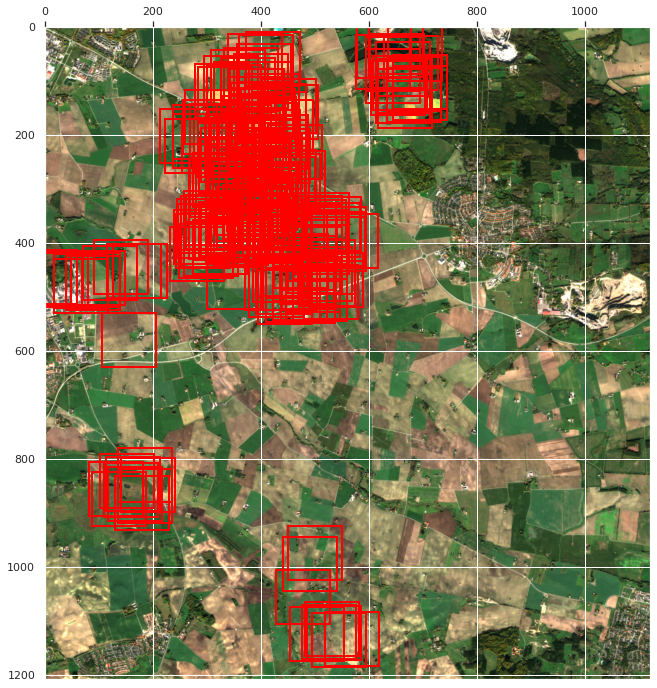

In [54]:
# Just visualizing the data - not an important step

tm=1
fig, ax = plt.subplots(figsize=(12,12))

img = np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [2, 1, 0]] * 6, 0, 1)

ax.xaxis.tick_top()
#ax.imshow(img)
#ax = plt.subplot(2, 2, 1)
#ax.xaxis.tick_top()
ax.imshow(img)
for sp in range(len(ny_centers)):
    ax.add_patch(patches.Rectangle((list(nx_centers)[sp],list(ny_centers)[sp]),2*r,2*r, fill=False, edgecolor='red', lw=2))
#ax.add_patch(patches.Rectangle((list(nx_centers)[47],list(ny_centers)[47]),2*r,2*r, fill=False, edgecolor='yellow', lw=2))
#ax.add_patch(patches.Rectangle((list(nx_centers)[10],list(ny_centers)[10]),2*r,2*r, fill=False, edgecolor='blue', lw=2))

#plt.xticks([])
#plt.yticks([])
#ax.set_aspect('auto')
#plt.title('RGB', fontsize=20)

These figures are from  eopatch_0_col-0_row-0 on  2018-10-12 10:30:19+00:00


Text(0.5, 1.0, 'Band 9')

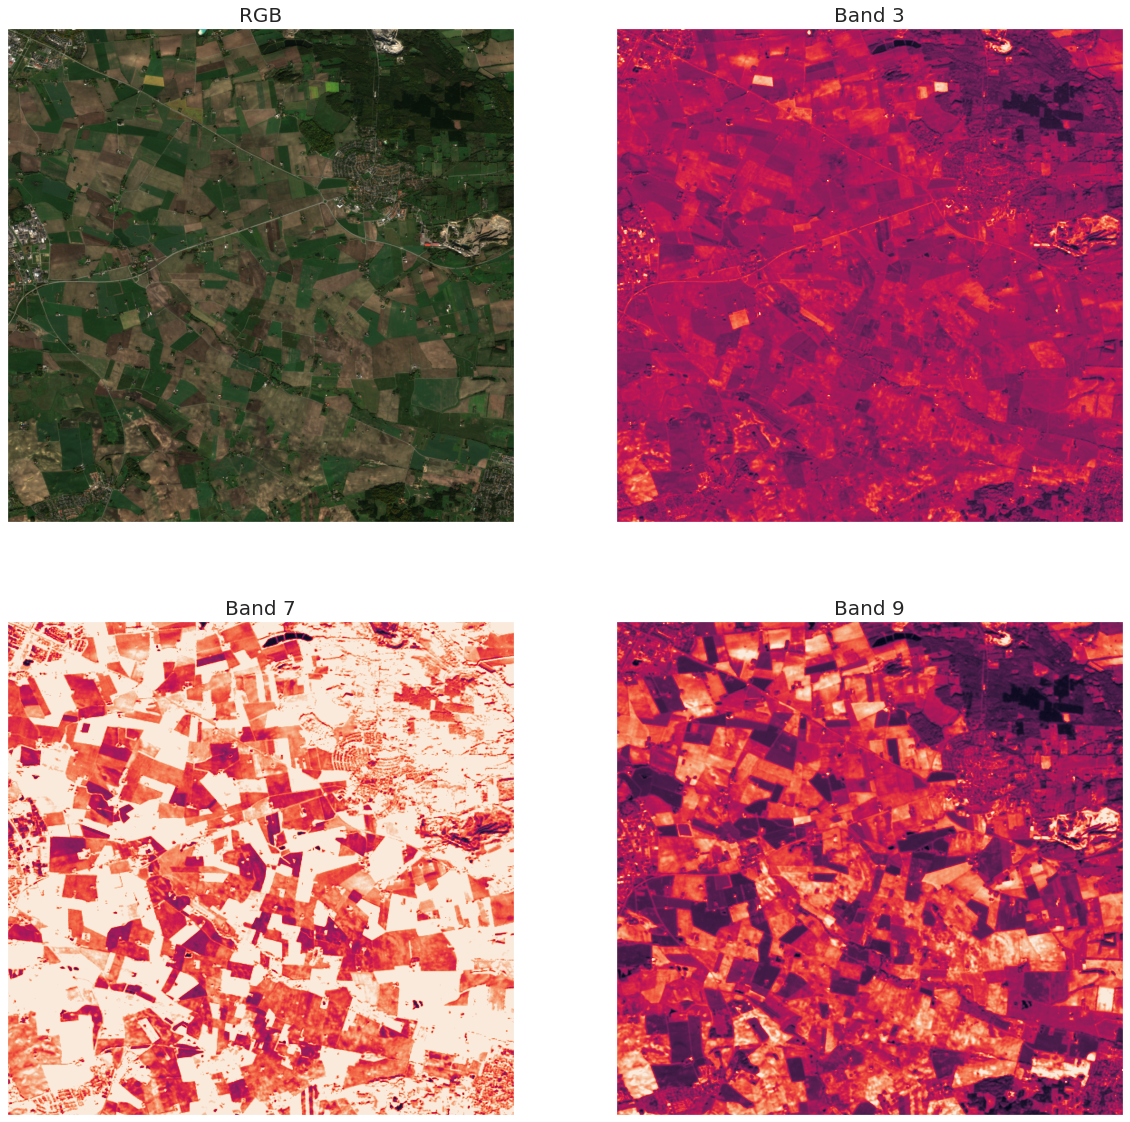

In [41]:
# Just visualizing the data - not an important step

eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)

tm = 0
time_chosen = eopatch.timestamp[tm]
print("These figures are from ",eopatch_name, "on ", time_chosen)
fig, ax = plt.subplots(figsize=(20,20))

ax = plt.subplot(2, 2, 1)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [2, 1, 0]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('RGB', fontsize=20)


ax = plt.subplot(2, 2, 2)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [3]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 3', fontsize=20)

ax = plt.subplot(2, 2, 3)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [7]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 7', fontsize=20)

ax = plt.subplot(2, 2, 4)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [9]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 9', fontsize=20)

# Weather Processing / Clean Up

only keep weather data from years 2018 and 2019

In [21]:
#tempdf#["w_precipitation"].unique()
#fieldf

In [22]:
# #cols_to_keep = ["time", "year", "temperature", "precipitation"]
# #ntempdf = tempdf[cols_to_keep]#["temperature"][:20]

# # First change the date column to datetime object
# # Convert date and time to just datetime object with only date
# format_string = "%Y-%m-%d"
# tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)

# # choose to keep year 2020
# tempdf = elim(tempdf, "w_year", year_chosen)

In [42]:
tempdf

w_precipitation  w_year     w_time
0                  0.0    2000 2000-10-19
1                  0.5    2000 2000-08-15
2                  8.3    2000 2000-08-14
3                  8.3    2000 2000-08-14
4                  8.3    2000 2000-08-14
...                ...     ...        ...
58811              0.0    2021 2021-03-25
58812              0.0    2021 2021-03-25
58813              0.0    2021 2021-03-25
58814              0.0    2021 2021-03-25
58815              0.0    2021 2021-03-26

[2749648 rows x 3 columns]

In [56]:
#fieldf

In [57]:
# # Create figure and plot space
# fig, ax = plt.subplots(figsize=(12, 12))

# # Add x-axis and y-axis
# ax.bar(tempdf["w_time"],#.index.values,
#        tempdf["w_precipitation"],#['DAILY_PRECIP'],
#        color='purple')
# # Add x-axis and y-axis
# #ax.scatter(boulder_july_2018.index.values,
# #        boulder_july_2018['precip'],
# #        color='purple')

# # Create figure and plot space
# #fig, ax = plt.subplots(figsize=(10, 10))

# # Add x-axis and y-axis
# #ax.plot(boulder_july_2018['date'],
# #        boulder_july_2018['precip'],
# #        color='purple')


# # Set title and labels for axes
# ax.set(xlabel="Date",
#        ylabel="Precipitation (inches)",
#        title="Daily Total Precipitation\nBoulder, Colorado in July 2018")

# # Rotate tick marks on x-axis
# plt.setp(ax.get_xticklabels(), rotation=45)

# # Set title and labels for axes
# #ax.set(xlabel="w_time",
# #       ylabel="w_precipitation",
# #       title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek")

# plt.show()


## Grouping weather data by Seasons, Month, week - we average here 

In [43]:
tempdf = all_dfs['w'].copy() # weather data
tempdf 

w_precipitation  w_year     w_time
0                  0.0    2000 2000-10-19
1                  0.5    2000 2000-08-15
2                  8.3    2000 2000-08-14
3                  8.3    2000 2000-08-14
4                  8.3    2000 2000-08-14
...                ...     ...        ...
58811              0.0    2021 2021-03-25
58812              0.0    2021 2021-03-25
58813              0.0    2021 2021-03-25
58814              0.0    2021 2021-03-25
58815              0.0    2021 2021-03-26

[2749648 rows x 3 columns]

In [44]:
# Need to move this in the deffunctions.ipynb file 

def cutoutseason(datafrin, seasonb, seasone):
    #print("call to whole datafrin (as a list):", datafrin)#["w_time"])
    #print("seasonb=", seasonb)
    # print(seasone)
    
    #datafrin['w_time'] = datafrin['w_time'].dt.date
    datafrout = datafrin[datafrin["w_time"]>seasonb]
    datafrout = datafrout[datafrout["w_time"]<seasone]
    
    return datafrout

Average of all columns

In [45]:
# Need to move this in the deffunctions.ipynb file 

# Defining the different possible groupings to choose from 
# 0: group all weather data into a single group
# 1: group all weather data per 3 season (specific dates)
# 2: group all weather data per day
# 3: group all weather data per week
# 4: group all weather data per month

def group_weather(argument, tempdf, fieldf, year_chosen):#, fieldID = 123456789):
      
    print("The following will be used for weather grouping:")
    # Find minimum date of seeding
    min_seed_date = min(fieldf[fieldf["f_seed_date"]>datetime.date(year_chosen-1,9,2)]["f_seed_date"])#.shape
    print("The earliest seeding date is ", min_seed_date)

    # Get harvest date for this dataset
    max_harv_date = max(fieldf[fieldf["f_harvest_date"]<datetime.date(year_chosen,9,1)]["f_harvest_date"])
    print("MAximum harvest time: ", max_harv_date)
    #max_harv_date = max(fieldf[fieldf["f_harvest_date"]>datetime.date(year_chosen,7,1)]["f_seed_date"])

    # Season 1: Seed-start-> 1st Nov
    season1st  = min_seed_date
    season1end = datetime.date(year_chosen-1,11,1) # November 1st
    
    # Season 2: 15 March  -> Midsummer
    season2st  = datetime.date(year_chosen,3,15)   # March 15
    season2end = datetime.date(year_chosen,6,25)   # June 25 (midsummer)
    
    # Season 3: Midsummer -> Harvest date
    season3st  = datetime.date(year_chosen,6,26)   # June 26 (after midsummer)
    season3end = max_harv_date

    print("Dates for season 1: ", season1st, season1end)
    print("Dates for season 2: ", season2st, season2end)
    print("Dates for season 3: ", season3st, season3end)

    format_string = "%Y-%m-%d"
    tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)
    
    ttempdf = tempdf.copy()
    ttempdf['w_time'] = tempdf['w_time'].dt.date # only for t1
    t1 = cutoutseason(ttempdf, season1st, season1end)

    if len(t1) == 0:
        print("Problems!!!")
        print("t1",t1)

    t2 = cutoutseason(ttempdf, season2st, season2end)  

    t3 = cutoutseason(ttempdf, season3st, season3end)

    tttempdf = t1.copy()
    tttempdf = tttempdf.append(t2, ignore_index=True)
    tttempdf = tttempdf.append(t3, ignore_index=True)
    
    ntempdf = pd.DataFrame(columns=tempdf.columns)
    
    if argument == 0:   # average all data into a single group (as an average)
        print("\n Grouping everything into single group! \n")

        ttempdf['w_time'] = cutoutseason(tttempdf, season1st, season1end)
        ntempdf.loc['mean'] = ttempdf.mean() # do an average over the total
        
    elif argument == 1: # average over specific seasons 
        print("\n Grouping into 3 seasons! \n")
 
        l = pd.Series([t1.mean()["w_precipitation"], t2.mean()["w_precipitation"], t3.mean()["w_precipitation"]])
        lw = pd.Series([t1.mean()["w_year"], t2.mean()["w_year"], t3.mean()["w_year"]])
        
        ntempdf["w_precipitation"] = l
        ntempdf["w_year"] = lw
        #ntempdf # this is weather grouped by season
    elif argument == 2: # group weather data per week (as an average)
        print("\n Grouping per day! \n")
        #format_string = "%Y-%m-%d"
        #tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)
        ttempdf = tttempdf.copy()
        
        groupby = "D"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = tttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
    elif argument == 3: # group weather data per week (as an average)
        print("\n Grouping per week! \n")
        format_string = "%Y-%m-%d"
        ttempdf = tttempdf.copy()
        ttempdf["w_time"] = pd.to_datetime(tttempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)
        
        groupby = "W"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = ttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
        
    elif argument == 4: # group weather data per month (as an average)
        print("\n Grouping per month! \n")
        # First change the date column to datetime object
        # Convert date and time to just datetime object with only date
        format_string = "%Y-%m-%d"
        ttempdf = tttempdf.copy()
        ttempdf["w_time"] = pd.to_datetime(tttempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)

        groupby = "M"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = ttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
    ntempdf.dropna(subset = ["w_year"], inplace=True) # remove rows of NaN
        
    
    return ntempdf

In [46]:
# Groupings to choose from: 
# 0: group all weather data into a single group
# 1: group all weather data into 3 seasons (specific dates)
# 2: group all weather data per day
# 3: group all weather data per week
# 4: group all weather data per month

new_tempdf = group_weather(4, tempdf, fieldf, year_chosen)

The following will be used for weather grouping:
The earliest seeding date is  2018-09-16
MAximum harvest time:  2019-08-23
Dates for season 1:  2018-09-16 2018-11-01
Dates for season 2:  2019-03-15 2019-06-25
Dates for season 3:  2019-06-26 2019-08-23

 Grouping per month! 



In [47]:
# look at the resulting grouping
clean_weather_df = new_tempdf.copy()
clean_weather_df

w_precipitation  w_year
w_time                             
2018-09-30         1.425000  2018.0
2018-10-31         1.747849  2018.0
2019-03-31         0.815385  2019.0
2019-04-30         0.344103  2019.0
2019-05-31         1.309429  2019.0
2019-06-30         1.893956  2019.0
2019-07-31         1.590323  2019.0
2019-08-31         2.463287  2019.0

## Clean weather dataframe 

# Harvest Data Processing/Clean Up

### Chose a specific year for harvest

In [48]:
# Note that field id = ...7601 is full of edgeflag == True ! 
# So we keep all data even if flagged as edge
#harvdf = all_dfs['h']
nharvdf = harvdf[harvdf["h_year"]==year_chosen]

# Remove data near field edges - according to provided flag within data
# nfielddf = elim(fielddf,'edgeflag', False)
# nfielddf = fielddf

Removing all edge data (i.e. edgeflag == True)

In [49]:
# Remove edges
#tempdf = nharvdf[nharvdf["edgeflag"]==False]
#tempdf
#nharvdf = nharvdf[nharvdf["edgeflag"]==False]
nharvdf#.iloc[232233,6]#["h_year"].unique()

h_coord_x  h_coord_y     h_blockid  h_year              h_time  \
0      388321.1  6166532.9  6.170337e+10    2019 2019-07-25 15:07:45   
1      388321.0  6166533.9  6.170337e+10    2019 2019-07-25 15:07:46   
2      388320.9  6166534.8  6.170337e+10    2019 2019-07-25 15:07:47   
3      388320.8  6166535.8  6.170337e+10    2019 2019-07-25 15:07:48   
4      388320.7  6166536.8  6.170337e+10    2019 2019-07-25 15:07:49   
...         ...        ...           ...     ...                 ...   
1634   421771.6  6172414.5  6.175371e+10    2019 2019-08-22 16:50:00   
1635   421769.9  6172415.0  6.175371e+10    2019 2019-08-22 16:50:01   
1636   421768.1  6172415.3  6.175371e+10    2019 2019-08-22 16:50:02   
1637   421766.3  6172415.2  6.175371e+10    2019 2019-08-22 16:50:03   
1638   421789.9  6172408.2  6.175371e+10    2019 2019-08-22 16:50:28   

      h_harvest  h_water_percentage  
0           3.4                15.4  
1           4.7                15.4  
2           6.2                15.5  
3           6.3                15.4  
4           6.9                15.5  
...         ...                 ...  
1634        2.3                16.5  
1635        1.5                16.6  
1636        1.1                16.5  
1637        0.6                16.5  
1638        0.4                16.7  

[386327 rows x 7 columns]

In [50]:
# Choose data from 2018
#nfielddf = elim(nfielddf, "year", 2018)
cols_to_keep = ["h_coord_x", "h_coord_y", "h_blockid", "h_harvest"]#, "h_water_percentage"]
#harv_rem_cols= ["crop",'data_id','farmname','data_geom','edgeflag']
#nnfielddf = cleanDataFrame(nfielddf, harv_rem_cols)
nnharvdf = nharvdf[cols_to_keep]
nnharvdf

h_coord_x  h_coord_y     h_blockid  h_harvest
0      388321.1  6166532.9  6.170337e+10        3.4
1      388321.0  6166533.9  6.170337e+10        4.7
2      388320.9  6166534.8  6.170337e+10        6.2
3      388320.8  6166535.8  6.170337e+10        6.3
4      388320.7  6166536.8  6.170337e+10        6.9
...         ...        ...           ...        ...
1634   421771.6  6172414.5  6.175371e+10        2.3
1635   421769.9  6172415.0  6.175371e+10        1.5
1636   421768.1  6172415.3  6.175371e+10        1.1
1637   421766.3  6172415.2  6.175371e+10        0.6
1638   421789.9  6172408.2  6.175371e+10        0.4

[386327 rows x 4 columns]

In [51]:
if (nnharvdf["h_harvest"]=='nan').any():
    print("Some NaN values exist - Need to remove")
else:
    print("No NaN values. Good to go!")

No NaN values. Good to go!


### Now work on spatial proximity grouping between datasets

First with Harvest: for a given square with side length 2r we group together (sum) all harvest data which are within that distance for each coordinate in the soil data.

#### Clean up all soil and harvest data which are not near each other (with r)

We choose a length r and any data which does not overlap is removed

In [52]:
nnharvdf.shape #.keys()
#nnharvdf.drop(11447)

(386327, 4)

In [53]:
nnsoildf.shape

(340, 13)

In [54]:
r

50

### Below sums harvest around harvest centers - which are half of original 

In [9]:
# we now reduce the amount of harvest centers 
# in general we have too much harvest locations in space so we reduce them here

temp_harv = nnharvdf.copy()
half_harv = temp_harv.iloc[::2, :] # use only half the harvest data
half_harv = half_harv.iloc[::2, :] # use only half the harvest data
half_harv = half_harv.iloc[::3, :] # use only half the harvest data

# and now we sum or average about these remaining harvest centers
new_harv_df = harvest_around_harvest(nnharvdf, half_harv,r) # group harvest around harvest data - takes for ever

NameError: name 'nnharvdf' is not defined

### Below centers soil around harvest centers - which must be reduced (code below) 

In [70]:
#temp_harv = nnharvdf.copy()

In [58]:
#temp_harv = temp_harv.iloc[::5, :]
#temp_harv.shape

In [59]:
nnsoildf.shape

(340, 13)

In [61]:
new_soil_df, new_harv_df = soil_around_harvest(nnsoildf, new_harv_df,r) # group around harvest data - takes for ever

100% 32194/32194 [00:34<00:00, 926.34it/s] 


Soil shape (11667, 4)
Harv shape (11667, 13)


In [62]:
# new_soil_df = new_soil_df.iloc[::2, :]
new_soil_df.shape

(11667, 13)

In [461]:
new_harv_df.shape

(11667, 5)

### Below centers harvest around soil centers! 

In [75]:
# Re-group harvest data according to coordinates in soil
#new_harv_df, new_soil_df = harvest_around_soil(nnharvdf, nnsoildf, r)

100% 340/340 [00:10<00:00, 32.90it/s]

Soil shape (189, 13)
Harv shape (189, 5)


In [253]:
#new_harv_df = df.copy()

In [462]:
df=new_harv_df
df

index  h_coord_x  h_coord_y       h_blockid  h_harvest
0          0  387667.96 6166250.42  61693376613.00       7.98
1          1  387668.43 6166250.02  61693376613.00       8.00
2          2  387668.81 6166249.97  61693376613.00       8.01
3          3  387672.03 6166249.23  61693376613.00       8.01
4          4  387673.51 6166252.59  61693376613.00       8.51
...      ...        ...        ...             ...        ...
11662  32189  422024.87 6172978.71 339645439755.50      10.78
11663  32190  422025.75 6172981.64 339645439755.50      10.72
11664  32191  422026.72 6172985.94 339645439755.50      10.64
11665  32192  422027.47 6172989.16 339645439755.50      10.56
11666  32193  422029.14 6172992.91 339645439755.50      10.43

[11667 rows x 5 columns]

In [463]:
BBox = (df.h_coord_x.min(),   df.h_coord_x.max(),   df.h_coord_y.min(), df.h_coord_y.max())
BBox

(387667.9556016595, 422029.1411504426, 6162008.513855421, 6173611.784854371)

In [464]:
patch2

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(19, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=19
)

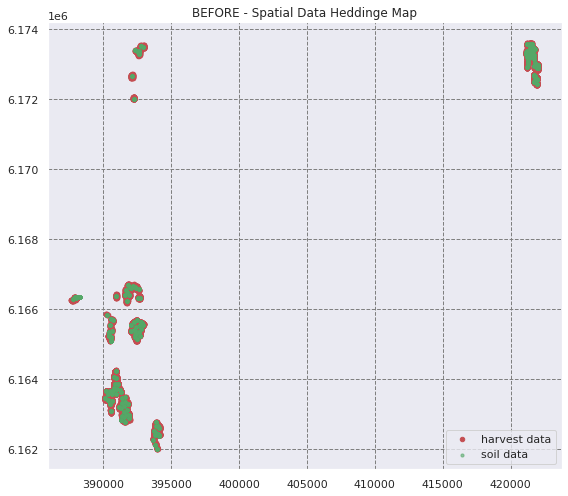

In [70]:
# Just visulizations - not important

fig, ax = plt.subplots(figsize = (8,7))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
ax.scatter(new_harv_df.h_coord_x, new_harv_df.h_coord_y, zorder=1, alpha= 1.0, c='r', s=20, label='harvest data')
#for xh, yh in zip(df.h_coord_x[10:], df.h_coord_y[10:]):
#    cir = plt.Circle((xh, yh), 10.0, color='k',fill=True)#False)
ax.scatter(new_soil_df.coord_x, new_soil_df.coord_y, zorder=1, alpha= 0.6, c='g', s=10, label = 'soil data')
ax.set_title('BEFORE - Spatial Data Heddinge Map')
#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
#ax.set_xlim(BBox[0]-2000,BBox[1]+1000)
#ax.set_ylim(BBox[2]+10000,BBox[3]-10000)
#ax.plot([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
#        color='k', label = '10km distance')
#ax.scatter([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
#           zorder=1, alpha= 1., c='k', s=10)
#for sp in range(len(xcenters)): # adding patches of bounding boxes with rectangle side: 2r
#    ax.add_patch(patches.Rectangle((list(xcenters)[sp],list(ycenters)[sp]),2*r,2*r, fill=True, edgecolor='black', lw=2))
#ax.add_patch(patches.Rectangle((388173.6, 6161829.1),2*r,2*r, fill=True, edgecolor='black', lw=2))
#ax.add_patch(patches.Rectangle((399381.06666666665, 6173904.3),2*r,2*r, fill=True, edgecolor='black', lw=2))


ax.grid(color='grey', linestyle='--', linewidth=1)
plt.tight_layout()   
leg = plt.legend(loc="best")

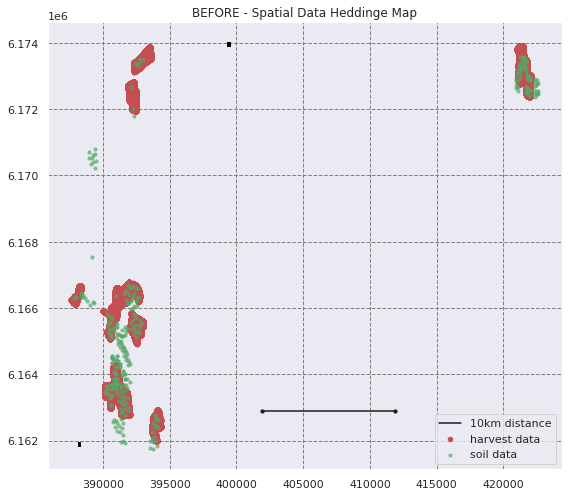

In [78]:
# Just visulizations - not important

fig, ax = plt.subplots(figsize = (8,7))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
ax.scatter(nnharvdf.h_coord_x, nnharvdf.h_coord_y, zorder=1, alpha= 1.0, c='r', s=20, label='harvest data')
#for xh, yh in zip(df.h_coord_x[10:], df.h_coord_y[10:]):
#    cir = plt.Circle((xh, yh), 10.0, color='k',fill=True)#False)
ax.scatter(nnsoildf.coord_x, nnsoildf.coord_y, zorder=1, alpha= 0.6, c='g', s=10, label = 'soil data')
ax.set_title('BEFORE - Spatial Data Heddinge Map')
#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
#ax.set_xlim(BBox[0]-2000,BBox[1]+1000)
#ax.set_ylim(BBox[2]+10000,BBox[3]-10000)
ax.plot([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
        color='k', label = '10km distance')
ax.scatter([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
           zorder=1, alpha= 1., c='k', s=10)
#for sp in range(len(xcenters)): # adding patches of bounding boxes with rectangle side: 2r
#    ax.add_patch(patches.Rectangle((list(xcenters)[sp],list(ycenters)[sp]),2*r,2*r, fill=True, edgecolor='black', lw=2))
ax.add_patch(patches.Rectangle((minx, miny),2*r,2*r, fill=True, edgecolor='black', lw=2))
ax.add_patch(patches.Rectangle((maxx, maxy),2*r,2*r, fill=True, edgecolor='black', lw=2))


ax.grid(color='grey', linestyle='--', linewidth=1)
plt.tight_layout()   
leg = plt.legend(loc="best")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


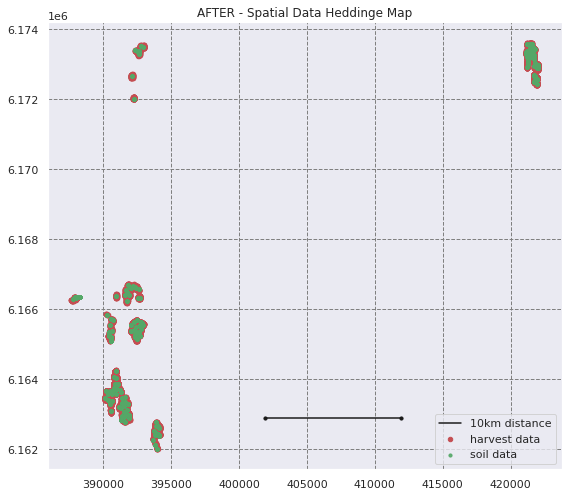

In [68]:
# Just visulizations - not important

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(new_harv_df.h_coord_x, new_harv_df.h_coord_y, zorder=1, alpha= 1.0, c='r', s=20, label='harvest data')
#for xh, yh in zip(df.h_coord_x[10:], df.h_coord_y[10:]):
#    cir = plt.Circle((xh, yh), 10.0, color='k',fill=True)#False)
ax.scatter(new_soil_df.coord_x, new_soil_df.coord_y, zorder=1, alpha= 0.9, c='g', s=10, label = 'soil data')
ax.set_title('AFTER - Spatial Data Heddinge Map')
#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
#ax.set_xlim(BBox[0],BBox[1])
#ax.set_ylim(BBox[2],BBox[3])
ax.plot([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
        color='k', label = '10km distance')
ax.scatter([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
           zorder=1, alpha= 1., c='k', s=10)
ax.grid(color='grey', linestyle='--', linewidth=1)
plt.tight_layout()   
leg = plt.legend()

In [72]:
keep_copy_new_harv_df = new_harv_df.copy()
keep_copy_new_soil_df = new_soil_df.copy()

In [73]:
#new_harv_df = keep_copy_new_harv_df.copy()
#new_soil_df = keep_copy_new_soil_df.copy()


Check if some values of harvest are 0 or non existent (nan)
Later on we remove all such rows from both harvest and soil (after merging them toghether)

In [465]:
#tempdf = newdf
#harvdf#["harvest"].unique()
print("note: for this to work both soil and re-grouped harvest (i.e. newdf) must have the exact same number of rows.")
print("Soil shape:", new_soil_df.shape)
print("Re-grouped Harvest shape:", new_harv_df.shape)

note: for this to work both soil and re-grouped harvest (i.e. newdf) must have the exact same number of rows.
Soil shape: (11667, 14)
Re-grouped Harvest shape: (11667, 5)


### Now average Sentinel image bands around each of the harvest centers 

In [466]:
bbox_from_image = list(patch2.bbox)
bbox_from_image
minx = bbox_from_image[0]
maxx = bbox_from_image[2]
miny = bbox_from_image[1]
maxy = bbox_from_image[3]

In [467]:
patch2

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(19, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=19
)

In [468]:


#Note r is 50 meters here

#Need to Convert centers

def conv_to_sentinel_image(x_c, y_c): # just input x and y coordinates to convert
    newxmax = 1208
    newymax = 1121
    newxmin = 0
    newymin = 0

    oldxmax = bbox_from_image[2]
    oldymax = bbox_from_image[3]

    oldxmin = bbox_from_image[0]
    oldymin = bbox_from_image[1]

    oldxdiff = oldxmax-oldxmin
    oldydiff = oldymax-oldymin

    #nx_centers = []
    #ny_centers = []
    #for x_coord, y_coord in zip(xcenters, ycenters):
    nx_c = int(newxmin+newxmax*(x_c-oldxmin)/oldxdiff)
    #nx_centers.append(nx_coord)

    ny_c = int(newymin+newymax*(y_c-oldymin)/oldydiff)
    #ny_centers.append(ny_coord)
    return nx_c, ny_c

In [469]:
#patch2.data["FEATURES"][0,:,:,1] # time 0, Band 1
#patch2.data["FEATURES"].shape
tm_num, sp_x, sp_y, bands = patch2.data["FEATURES"].shape

In [470]:
new_harv_df = new_harv_df.reset_index() # some indeces missing
new_soil_df = new_soil_df.reset_index()

In [471]:
patch2.timestamp[0].month

10

In [85]:
#temp_harv_df = temp_harv_df.reset_index()
#temp_soil_df = temp_soil_df.droplevel(0).reset_index()

In [474]:

# Must reset index if concat or join is used!
inputdf = new_soil_df.reset_index(drop=True)
##newharvdf = newharvdf.reset_index(drop=True)
newharvdf    = new_harv_df.reset_index(drop=True)
spatialvecdf = pd.concat([inputdf, newharvdf], axis=1)

# Removing also the coordinates now
spatialvecdf = spatialvecdf.drop(columns=["h_coord_x", "h_coord_y"])
spatialvecdf

level_0  index  h_coord_x  h_coord_y       h_blockid  h_harvest
0            0      0  387667.96 6166250.42  61693376613.00       7.98
1            1      1  387668.43 6166250.02  61693376613.00       8.00
2            2      2  387668.81 6166249.97  61693376613.00       8.01
3            3      3  387672.03 6166249.23  61693376613.00       8.01
4            4      4  387673.51 6166252.59  61693376613.00       8.51
...        ...    ...        ...        ...             ...        ...
11662    11662  32189  422024.87 6172978.71 339645439755.50      10.78
11663    11663  32190  422025.75 6172981.64 339645439755.50      10.72
11664    11664  32191  422026.72 6172985.94 339645439755.50      10.64
11665    11665  32192  422027.47 6172989.16 339645439755.50      10.56
11666    11666  32193  422029.14 6172992.91 339645439755.50      10.43

[11667 rows x 6 columns]

In [473]:
# used to remove data in harvest and soil which is not in the Sentinel image
# removes data for a specific feature if below minv and above maxv

def remove_above_below(dfin, feature, minv, maxv):
    dfin = dfin[dfin[feature]>=minv] # keep all above minimum
    dfin = dfin[dfin[feature]<=maxv] # keep all above maximum
    
    return dfin

def apply_fun_above(dfin, feat_name, minx, maxx, miny, maxy):
    temp_df = remove_above_below(dfin, feat_name+"_x", minx, maxx)
    temp_df = remove_above_below(temp_df, feat_name+"_y", miny, maxy)
    dfout   = temp_df.reset_index(drop=True)

    return dfout

def check_nans(dfin):
    num = dfin.shape[0] - dfin.dropna().shape[0]
    if num == 0:
        mes = "Good to go! No NaNs."
    else:
        mes = "Need to clean up! There are "+str(num)+" NaNs."
    return print(mes)

def remove_nans(dfin):
    dfout = dfin.dropna()
    return dfout

In [87]:
# temp_soil_df = remove_above_below(new_soil_df, "coord_x", minx, maxx)
# temp_soil_df = remove_above_below(temp_soil_df, "coord_y", miny, maxy)
# temp_soil_df = temp_soil_df.reset_index(drop=True)
# temp_soil_df # to see the result

In [475]:
temp_spatial_df = apply_fun_above(spatialvecdf, "h_coord", minx, maxx, miny, maxy)
temp_spatial_df.shape

(8460, 6)

In [476]:
temp_spatial_df

level_0  index  h_coord_x  h_coord_y       h_blockid  h_harvest
0         227    771  390149.57 6163410.24 339148689903.00      10.58
1         228    774  390149.82 6163416.11 339380895168.05      10.57
2         229    777  390150.02 6163417.24 339148689903.00      10.55
3         230    781  390150.85 6163424.41 339386874702.78      10.43
4         231    782  390150.94 6163424.64 338911320106.82      10.44
...       ...    ...        ...        ...             ...        ...
8455     8682  27099  394189.63 6162632.55  61663431237.00      12.16
8456     8683  27100  394190.39 6162424.38  61663431237.00       9.65
8457     8684  27105  394191.52 6162580.06  61663431237.00      11.90
8458     8685  27106  394191.76 6162592.60  61663431237.00      11.95
8459     8686  27111  394192.95 6162566.25  61663431237.00      11.88

[8460 rows x 6 columns]

In [477]:
# reducing the number of rows

red_spatial_df = temp_spatial_df.copy()
#red_spatial_df = red_spatial_df[::2]
red_spatial_df = red_spatial_df[::3]
red_spatial_df = red_spatial_df.reset_index(drop=True)
red_spatial_df.shape

(2820, 6)

In [478]:
# Checking for number of nans in the dataframe
check_nans(red_spatial_df)


Good to go! No NaNs.


### Now creating the Sentinel dataframe 

In [480]:
patch2.timestamp[2].month

10

In [481]:
# First create the column names for the new dataframe
# will be a mixture of time_instance + band name

col_names = []
for tm in patch2.timestamp: #[0].month
    tm_inst  = str(tm.year)+'_'+str(tm.month)+'_'+str(tm.day)
    print(tm_inst)
    for bd in ['B1','B2','B3','B4','B5','B6','B7','B8','B8a','B9','NDVI','NDWI','NORM']:
        col_names.append(tm_inst+'_'+bd)
print("Number of names created:", len(col_names))

2018_10_12
2018_10_20
2018_10_28
2019_3_5
2019_3_13
2019_3_21
2019_3_29
2019_4_6
2019_4_14
2019_4_22
2019_4_30
2019_5_8
2019_5_16
2019_5_24
2019_6_1
2019_6_9
2019_6_17
2019_6_25
2019_7_3
Number of names created: 247


#### Group image around centers from harvest data 

In [483]:
# groups image based on centers from harvest data
# run this on those centers of the image you are interested at

# col_name = []
# for harv_num in range(len(red_spatial_df[:1])):
#     #col_name.append(str(harv_num)+'x')
#     #col_name.append(str(harv_num)+'x')
#     for tm in range(tm_num): # for each time (10 times exist)
#         #col_name.append(str(tm))
#         for bnd in range(bands):
#             col_name.append(str(tm)+str(bnd))
            
# print(col_name)

sent_df = pd.DataFrame() # create an empty dataframe to populate with averages
for harv_num in tqdm(range(len(red_spatial_df))):
    row = []
    #row.append(temp_harv_df["h_coord_x"][harv_num])
    #row.append(temp_harv_df["h_coord_y"][harv_num])
    
    for tm in range(tm_num): # for each time (10 times exist)

        #row.append(patch2.timestamp[tm].month)
        for bnd in range(bands): # for each band (13 bands)
            
            #row.append(bnd)
            #bbox_from_image = list(patch2.bbox)
            #print(bbox_from_image)
            #print(total_image.shape)
            #print(total_image[3:10,10:20])
            #print(total_image[3:10,10:20].mean())
            
            temp_x = red_spatial_df["h_coord_x"][harv_num] # x center
            
            #if temp_x < minx or temp_x>maxx:
            #    continue
            temp_y = red_spatial_df["h_coord_y"][harv_num] # y center
            #if temp_y < miny or temp_y>maxy:
            #    continue
            
            n_x, n_y = conv_to_sentinel_image(temp_x, temp_y)# translate to figure coord
            local_bb_image = patch2.data["FEATURES"][tm,n_x-r:n_x+r, n_y-r:n_y+r,bnd]
            #print(temp_x, temp_y)
            #print((temp_x-minx)*1211/(maxx-minx))
            
            #print(n_x, n_y)
            
            #print(n_x-r, n_x+r, n_y-r, n_y+r)
            #local_bb = total_image[] # part of image with these centers
            #print(local_bb)
            #print(local_bb.mean())   # obtain a local average of the image
            row.append(local_bb_image.mean())
        
    sent_df = sent_df.append(pd.Series(row),ignore_index=True)
sent_df.columns = col_names
sent_df

100% 2820/2820 [01:28<00:00, 31.90it/s]


2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  \
0              0.05           0.08           0.07           0.12   
1              0.05           0.08           0.07           0.12   
2              0.05           0.08           0.07           0.12   
3              0.05           0.08           0.07           0.12   
4              0.05           0.08           0.07           0.12   
...             ...            ...            ...            ...   
2815           0.05           0.08           0.06           0.12   
2816           0.05           0.08           0.06           0.12   
2817           0.05           0.08           0.06           0.12   
2818           0.05           0.08           0.06           0.12   
2819           0.05           0.08           0.06           0.12   

      2018_10_12_B5  2018_10_12_B6  2018_10_12_B7  2018_10_12_B8  \
0              0.25           0.29           0.29           0.30   
1              0.25           0.28           0.29           0.30   
2              0.25           0.28           0.29           0.30   
3              0.25           0.28           0.29           0.30   
4              0.25           0.28           0.28           0.29   
...             ...            ...            ...            ...   
2815           0.29           0.33           0.33           0.35   
2816           0.29           0.33           0.34           0.35   
2817           0.30           0.34           0.34           0.35   
2818           0.30           0.34           0.34           0.35   
2819           0.29           0.33           0.34           0.35   

      2018_10_12_B8a  2018_10_12_B9  ...  2019_7_3_B4  2019_7_3_B5  \
0               0.20           0.15  ...         0.13         0.28   
1               0.20           0.15  ...         0.13         0.28   
2               0.20           0.15  ...         0.13         0.28   
3               0.20           0.15  ...         0.13         0.28   
4               0.20           0.15  ...         0.13         0.28   
...              ...            ...  ...          ...          ...   
2815            0.17           0.10  ...         0.13         0.27   
2816            0.17           0.10  ...         0.13         0.27   
2817            0.17           0.10  ...         0.13         0.27   
2818            0.17           0.10  ...         0.13         0.27   
2819            0.17           0.10  ...         0.13         0.27   

      2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  2019_7_3_B8a  2019_7_3_B9  \
0            0.34         0.35         0.37          0.16         0.09   
1            0.34         0.35         0.37          0.16         0.09   
2            0.34         0.35         0.37          0.16         0.09   
3            0.34         0.35         0.37          0.16         0.09   
4            0.34         0.35         0.37          0.16         0.09   
...           ...          ...          ...           ...          ...   
2815         0.32         0.33         0.34          0.18         0.11   
2816         0.32         0.33         0.34          0.18         0.11   
2817         0.32         0.33         0.34          0.17         0.11   
2818         0.32         0.33         0.34          0.18         0.11   
2819         0.32         0.33         0.34          0.18         0.11   

      2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0              0.68          -0.63           0.73  
1              0.68          -0.64           0.73  
2              0.68          -0.64           0.73  
3              0.68          -0.64           0.73  
4              0.68          -0.64           0.73  
...             ...            ...            ...  
2815           0.60          -0.57           0.70  
2816           0.61          -0.58           0.70  
2817           0.62          -0.58           0.71  
2818           0.62          -0.58           0.71  
2819           0.61          -0.58           0.70  

[2820 rows x 247 

In [518]:
copy_of_sent_df = sent_df.copy()
#sent_df = copy_of_sent_df.copy()

In [519]:
sent_df

2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  \
0              0.05           0.08           0.07           0.12   
1              0.05           0.08           0.07           0.12   
2              0.05           0.08           0.07           0.12   
3              0.05           0.08           0.07           0.12   
4              0.05           0.08           0.07           0.12   
...             ...            ...            ...            ...   
2815           0.05           0.08           0.06           0.12   
2816           0.05           0.08           0.06           0.12   
2817           0.05           0.08           0.06           0.12   
2818           0.05           0.08           0.06           0.12   
2819           0.05           0.08           0.06           0.12   

      2018_10_12_B5  2018_10_12_B6  2018_10_12_B7  2018_10_12_B8  \
0              0.25           0.29           0.29           0.30   
1              0.25           0.28           0.29           0.30   
2              0.25           0.28           0.29           0.30   
3              0.25           0.28           0.29           0.30   
4              0.25           0.28           0.28           0.29   
...             ...            ...            ...            ...   
2815           0.29           0.33           0.33           0.35   
2816           0.29           0.33           0.34           0.35   
2817           0.30           0.34           0.34           0.35   
2818           0.30           0.34           0.34           0.35   
2819           0.29           0.33           0.34           0.35   

      2018_10_12_B8a  2018_10_12_B9  ...  2019_7_3_B4  2019_7_3_B5  \
0               0.20           0.15  ...         0.13         0.28   
1               0.20           0.15  ...         0.13         0.28   
2               0.20           0.15  ...         0.13         0.28   
3               0.20           0.15  ...         0.13         0.28   
4               0.20           0.15  ...         0.13         0.28   
...              ...            ...  ...          ...          ...   
2815            0.17           0.10  ...         0.13         0.27   
2816            0.17           0.10  ...         0.13         0.27   
2817            0.17           0.10  ...         0.13         0.27   
2818            0.17           0.10  ...         0.13         0.27   
2819            0.17           0.10  ...         0.13         0.27   

      2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  2019_7_3_B8a  2019_7_3_B9  \
0            0.34         0.35         0.37          0.16         0.09   
1            0.34         0.35         0.37          0.16         0.09   
2            0.34         0.35         0.37          0.16         0.09   
3            0.34         0.35         0.37          0.16         0.09   
4            0.34         0.35         0.37          0.16         0.09   
...           ...          ...          ...           ...          ...   
2815         0.32         0.33         0.34          0.18         0.11   
2816         0.32         0.33         0.34          0.18         0.11   
2817         0.32         0.33         0.34          0.17         0.11   
2818         0.32         0.33         0.34          0.18         0.11   
2819         0.32         0.33         0.34          0.18         0.11   

      2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0              0.68          -0.63           0.73  
1              0.68          -0.64           0.73  
2              0.68          -0.64           0.73  
3              0.68          -0.64           0.73  
4              0.68          -0.64           0.73  
...             ...            ...            ...  
2815           0.60          -0.57           0.70  
2816           0.61          -0.58           0.70  
2817           0.62          -0.58           0.71  
2818           0.62          -0.58           0.71  
2819           0.61          -0.58           0.70  

[2820 rows x 247 

In [520]:
#sent_df.columns = col_names
check_nans(sent_df)

Need to clean up! There are 311 NaNs.


In [522]:
new_sp_vec_df = pd.concat([red_spatial_df,sent_df], axis=1)
check_nans(new_sp_vec_df)
new_sp_vec_df

Need to clean up! There are 311 NaNs.


level_0  index  h_coord_x  h_coord_y       h_blockid  h_harvest  \
0         227    771  390149.57 6163410.24 339148689903.00      10.58   
1         230    781  390150.85 6163424.41 339386874702.78      10.43   
2         233    800  390153.44 6163416.12 338939582674.86      10.65   
3         236    807  390154.64 6163425.38 339148689903.00      10.54   
4         239    818  390155.70 6163440.33 339377827220.70      10.29   
...       ...    ...        ...        ...             ...        ...   
2815     8672  27078  394181.52 6162576.53  61663431237.00      12.16   
2816     8675  27085  394184.27 6162612.22  61663431237.00      12.16   
2817     8678  27089  394185.18 6162662.29  61663431237.00      12.14   
2818     8681  27097  394188.03 6162646.38  61663431237.00      12.14   
2819     8684  27105  394191.52 6162580.06  61663431237.00      11.90   

      2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  ...  \
0              0.05           0.08           0.07           0.12  ...   
1              0.05           0.08           0.07           0.12  ...   
2              0.05           0.08           0.07           0.12  ...   
3              0.05           0.08           0.07           0.12  ...   
4              0.05           0.08           0.07           0.12  ...   
...             ...            ...            ...            ...  ...   
2815           0.05           0.08           0.06           0.12  ...   
2816           0.05           0.08           0.06           0.12  ...   
2817           0.05           0.08           0.06           0.12  ...   
2818           0.05           0.08           0.06           0.12  ...   
2819           0.05           0.08           0.06           0.12  ...   

      2019_7_3_B4  2019_7_3_B5  2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  \
0            0.13         0.28         0.34         0.35         0.37   
1            0.13         0.28         0.34         0.35         0.37   
2            0.13         0.28         0.34         0.35         0.37   
3            0.13         0.28         0.34         0.35         0.37   
4            0.13         0.28         0.34         0.35         0.37   
...           ...          ...          ...          ...          ...   
2815         0.13         0.27         0.32         0.33         0.34   
2816         0.13         0.27         0.32         0.33         0.34   
2817         0.13         0.27         0.32         0.33         0.34   
2818         0.13         0.27         0.32         0.33         0.34   
2819         0.13         0.27         0.32         0.33         0.34   

      2019_7_3_B8a  2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0             0.16         0.09           0.68          -0.63           0.73  
1             0.16         0.09           0.68          -0.64           0.73  
2             0.16         0.09           0.68          -0.64           0.73  
3             0.16         0.09           0.68          -0.64           0.73  
4             0.16         0.09           0.68          -0.64           0.73  
...            ...          ...            ...            ...            ...  
2815          0.18         0.11           0.60          -0.57           0.70  
2816          0.18         0.11           0.61          -0.58           0.70  
2817          0.17         0.11           0.62          -0.58           0.71  
2818          0.18         0.11           0.62          -0.58           0.71  
2819          0.18         0.11           0.61          -0.58           0.70  

[2820 rows x 253 columns]

In [523]:

cleaned_df = remove_nans(new_sp_vec_df)
check_nans(cleaned_df)
sent_df = cleaned_df.copy()
sent_df.reset_index(drop=True)
sent_df.shape

Good to go! No NaNs.


(2509, 253)

In [524]:
# put together all soil, harvest and sentinel data
# to do this number of rows must match
print("Shape of Sentinel data is:", sent_df.shape)
#print("Shape of soil and harvest data is:", red_spatial_df.shape)

Shape of Sentinel data is: (2509, 253)


# Constructing the input vector from all data

First in space: Here we construct the input vector changing in space: i.e. Soil and Harvest data only

The row in both soil and re-grouped harvest are now the same so we simply add more columns in the new dataframe: spatialvecdf

In [525]:
sent_df

level_0  index  h_coord_x  h_coord_y       h_blockid  h_harvest  \
0         227    771  390149.57 6163410.24 339148689903.00      10.58   
1         230    781  390150.85 6163424.41 339386874702.78      10.43   
2         233    800  390153.44 6163416.12 338939582674.86      10.65   
3         236    807  390154.64 6163425.38 339148689903.00      10.54   
4         239    818  390155.70 6163440.33 339377827220.70      10.29   
...       ...    ...        ...        ...             ...        ...   
2815     8672  27078  394181.52 6162576.53  61663431237.00      12.16   
2816     8675  27085  394184.27 6162612.22  61663431237.00      12.16   
2817     8678  27089  394185.18 6162662.29  61663431237.00      12.14   
2818     8681  27097  394188.03 6162646.38  61663431237.00      12.14   
2819     8684  27105  394191.52 6162580.06  61663431237.00      11.90   

      2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  ...  \
0              0.05           0.08           0.07           0.12  ...   
1              0.05           0.08           0.07           0.12  ...   
2              0.05           0.08           0.07           0.12  ...   
3              0.05           0.08           0.07           0.12  ...   
4              0.05           0.08           0.07           0.12  ...   
...             ...            ...            ...            ...  ...   
2815           0.05           0.08           0.06           0.12  ...   
2816           0.05           0.08           0.06           0.12  ...   
2817           0.05           0.08           0.06           0.12  ...   
2818           0.05           0.08           0.06           0.12  ...   
2819           0.05           0.08           0.06           0.12  ...   

      2019_7_3_B4  2019_7_3_B5  2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  \
0            0.13         0.28         0.34         0.35         0.37   
1            0.13         0.28         0.34         0.35         0.37   
2            0.13         0.28         0.34         0.35         0.37   
3            0.13         0.28         0.34         0.35         0.37   
4            0.13         0.28         0.34         0.35         0.37   
...           ...          ...          ...          ...          ...   
2815         0.13         0.27         0.32         0.33         0.34   
2816         0.13         0.27         0.32         0.33         0.34   
2817         0.13         0.27         0.32         0.33         0.34   
2818         0.13         0.27         0.32         0.33         0.34   
2819         0.13         0.27         0.32         0.33         0.34   

      2019_7_3_B8a  2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0             0.16         0.09           0.68          -0.63           0.73  
1             0.16         0.09           0.68          -0.64           0.73  
2             0.16         0.09           0.68          -0.64           0.73  
3             0.16         0.09           0.68          -0.64           0.73  
4             0.16         0.09           0.68          -0.64           0.73  
...            ...          ...            ...            ...            ...  
2815          0.18         0.11           0.60          -0.57           0.70  
2816          0.18         0.11           0.61          -0.58           0.70  
2817          0.17         0.11           0.62          -0.58           0.71  
2818          0.18         0.11           0.62          -0.58           0.71  
2819          0.18         0.11           0.61          -0.58           0.70  

[2509 rows x 253 columns]

In [521]:
# See how much of the data has slope -9999
#len(spatialvecdf[spatialvecdf["slope_max"]==-9999.0000])
#check_nans(new_sp_vec_df)

In [526]:
#new_sp_vec_df

We now remove all rows which contain 0 or non-existant values for harvest

In [506]:
# # Remove values of harvest which are near 0 - cutoff values here is 5
# #spatialvecdf = spatialvecdf[spatialvecdf["harvest"]>=5.]
# temporarydf = new_sp_vec_df #All spatial + sentinel data #spatialvecdf 

# # Remove rows which contain zero or nan for Harvest from the dataframe
# temporarydf = temporarydf[~(temporarydf["h_harvest"] == 0.0)]#axis=1)]
# temporarydf = temporarydf[temporarydf['h_harvest'].notna()]
# spatialvecdf = temporarydf
# spatialvecdf

In [507]:
# check how many nans we might have
#check_nans(spatialvecdf)

In [508]:
# cleaned_spatial = remove_nans(spatialvecdf)
# check_nans(cleaned_spatial)

### Look at both time and spatial vectors now

In [176]:
#clean_weather_df

timevecdf = clean_weather_df.copy()# ntempdf
#timevecdf = timevecdf.iloc[0,:]
timevecdf

w_precipitation  w_year
w_time                             
2018-09-30         1.425000  2018.0
2018-10-31         1.747849  2018.0
2019-03-31         0.815385  2019.0
2019-04-30         0.344103  2019.0
2019-05-31         1.309429  2019.0
2019-06-30         1.893956  2019.0
2019-07-31         1.590323  2019.0
2019-08-31         2.463287  2019.0

In [96]:
#timevecdf["w_precipitation"]

## Now putting together the full spatial and temporal inputvector

Now include the weather data which is constant in all space - for both soil and harvest for all cordinates above!

Weather changes in time. Soil and Harvest change in space 

28 weeks of time data.  Assuming 6 locations of data (each dataset in space for this field. Total: 6 input vectors!

(note each data location contains lots of data: PH, Mg, K, precipitation for week1, precip. for week2, etc...)

In [97]:
# inputvectordf = pd.DataFrame()#columns=list(timevecdf.keys())+list(spatialvecdf.keys()))
# for tim in tqdm(range(len(timevecdf))):       # loops through all time points in time input df (weather)
#     timrowdf = timevecdf.iloc[tim,:]                # Takes a single row from time dataframe
#     #print(timrowdf)
#     for sp in range(len(spatialvecdf)): # loops through all space points in spatial input df (soil, harvest)
#         sprowdf = spatialvecdf.iloc[sp,:]          # Takes a single row from space dataframe
#         tempvectordf= pd.concat([timrowdf, sprowdf])  # creates new row in total input vector by combinoing above
        
#         inputvectordf = inputvectordf.append(tempvectordf, ignore_index=True)
# inputvectordf

In [346]:
time_names = ['precip_m'+str(l+1) for l in range(len(timevecdf.index))] # obtain names of all rows in weather data
inputvectordf = pd.DataFrame()
#inputvectordf = pd.DataFrame(columns=list(spatialvecdf.keys())+list(time_names))# creates new dataframe column names

all_weather_prec = list(timevecdf["w_precipitation"])
#all_weather_prec = [timevecdf["w_precipitation"]]
for sp in range(len(spatialvecdf)):        # loops through all space points in spatial input df (soil, harvest)
    sprowdf   = list(spatialvecdf.iloc[sp,:])# Takes a single row from space dataframe
    temp_list = all_weather_prec
    #list(sprowdf.extend(all_weather_prec)).reset_index(drop=True, inplace=True)
    #aaa.reset_index()
    #print(sprowdf)#temp_list)
    inputvectordf = inputvectordf.append(pd.Series(sprowdf+temp_list),ignore_index=True, verify_integrity=False, sort=None)#+all_weather_prec),ignore_index=True)
inputvectordf = inputvectordf.set_axis(list(spatialvecdf.keys())+list(time_names), axis=1)
#     for tim in tqdm(range(len(timevecdf))):# loops through all time points in time input df (weather)
#         timrowdf = timevecdf.iloc[tim,:]          # Takes a single row from time dataframe
        
#         tempvectordf= pd.concat([timrowdf, sprowdf])  # creates new row in total input vector by combinoing above
#         inputvectordf = inputvectordf.append(tempvectordf, ignore_index=True)

In [177]:
#inputvectordf = spatialvecdf
#inputvectordf = cleaned_spatial.copy()

In [532]:
inputvectordf.keys()

Index(['level_0', 'index', 'h_coord_x', 'h_coord_y', 'h_blockid', 'h_harvest',
       '2018_10_12_B1', '2018_10_12_B2', '2018_10_12_B3', '2018_10_12_B4',
       ...
       '2019_7_3_B4', '2019_7_3_B5', '2019_7_3_B6', '2019_7_3_B7',
       '2019_7_3_B8', '2019_7_3_B8a', '2019_7_3_B9', '2019_7_3_NDVI',
       '2019_7_3_NDWI', '2019_7_3_NORM'],
      dtype='object', length=253)

In [528]:
#print("There are in the end ", len(inputvectordf["h_blockid"].unique()), " fields left used in this analysis")

## Finally combining the Sentinel input vector (space-time) with this newly created input vector (space time) 

We combine the two input vectors by throwing away all space time points not in both vectors

In [533]:
inputvectordf# = sent_df.copy()

level_0  index  h_coord_x  h_coord_y       h_blockid  h_harvest  \
0         227    771  390149.57 6163410.24 339148689903.00      10.58   
1         230    781  390150.85 6163424.41 339386874702.78      10.43   
2         233    800  390153.44 6163416.12 338939582674.86      10.65   
3         236    807  390154.64 6163425.38 339148689903.00      10.54   
4         239    818  390155.70 6163440.33 339377827220.70      10.29   
...       ...    ...        ...        ...             ...        ...   
2815     8672  27078  394181.52 6162576.53  61663431237.00      12.16   
2816     8675  27085  394184.27 6162612.22  61663431237.00      12.16   
2817     8678  27089  394185.18 6162662.29  61663431237.00      12.14   
2818     8681  27097  394188.03 6162646.38  61663431237.00      12.14   
2819     8684  27105  394191.52 6162580.06  61663431237.00      11.90   

      2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  ...  \
0              0.05           0.08           0.07           0.12  ...   
1              0.05           0.08           0.07           0.12  ...   
2              0.05           0.08           0.07           0.12  ...   
3              0.05           0.08           0.07           0.12  ...   
4              0.05           0.08           0.07           0.12  ...   
...             ...            ...            ...            ...  ...   
2815           0.05           0.08           0.06           0.12  ...   
2816           0.05           0.08           0.06           0.12  ...   
2817           0.05           0.08           0.06           0.12  ...   
2818           0.05           0.08           0.06           0.12  ...   
2819           0.05           0.08           0.06           0.12  ...   

      2019_7_3_B4  2019_7_3_B5  2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  \
0            0.13         0.28         0.34         0.35         0.37   
1            0.13         0.28         0.34         0.35         0.37   
2            0.13         0.28         0.34         0.35         0.37   
3            0.13         0.28         0.34         0.35         0.37   
4            0.13         0.28         0.34         0.35         0.37   
...           ...          ...          ...          ...          ...   
2815         0.13         0.27         0.32         0.33         0.34   
2816         0.13         0.27         0.32         0.33         0.34   
2817         0.13         0.27         0.32         0.33         0.34   
2818         0.13         0.27         0.32         0.33         0.34   
2819         0.13         0.27         0.32         0.33         0.34   

      2019_7_3_B8a  2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0             0.16         0.09           0.68          -0.63           0.73  
1             0.16         0.09           0.68          -0.64           0.73  
2             0.16         0.09           0.68          -0.64           0.73  
3             0.16         0.09           0.68          -0.64           0.73  
4             0.16         0.09           0.68          -0.64           0.73  
...            ...          ...            ...            ...            ...  
2815          0.18         0.11           0.60          -0.57           0.70  
2816          0.18         0.11           0.61          -0.58           0.70  
2817          0.17         0.11           0.62          -0.58           0.71  
2818          0.18         0.11           0.62          -0.58           0.71  
2819          0.18         0.11           0.61          -0.58           0.70  

[2509 rows x 253 columns]

Input vector is now created above. 

We now clean it up (i.e. remove a few uninteresting columns for the learning)
Then we will start predicting harvest based on the remaining data

# Clearing up the combined input vector

In [513]:
#print("in the final input vector there are a total of ", len(inputvectordf["h_blockid"].unique()), "different fields")

In [531]:
inputvectordf["h_harvest"]

0      10.58
1      10.43
2      10.65
3      10.54
4      10.29
        ... 
2815   12.16
2816   12.16
2817   12.14
2818   12.14
2819   11.90
Name: h_harvest, Length: 2509, dtype: float64

In [535]:
invecdf = inputvectordf.drop(columns=["h_blockid","h_coord_y","h_coord_x","level_0","index"])#,"w_year","w_time"])


In [183]:
# Make a column numeric - somehow it was not
#invecdf["clay_percentage"] = pd.to_numeric(invecdf["clay_percentage"])

In [184]:
# remove also these columns
#invecdf["class_k"] = pd.to_numeric(invecdf["class_k"])
#invecdf["class_p"] = pd.to_numeric(invecdf["class_p"])
invecdf["s_clay100"] = pd.to_numeric(invecdf["s_clay100"])

In [536]:
unique_h = invecdf.h_harvest.unique()
max_h = np.max(unique_h)
min_h = np.min(unique_h)
print("There are ",len(unique_h)," unique harvest values.\n","The max is",max_h,"and the min is",min_h)
#invecdf.s_clay100.unique()

There are  2509  unique harvest values.
 The max is 18.886514886164626 and the min is 6.407073170731697


In [537]:
invecdf.head()

h_harvest  2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  \
0      10.58           0.05           0.08           0.07           0.12   
1      10.43           0.05           0.08           0.07           0.12   
2      10.65           0.05           0.08           0.07           0.12   
3      10.54           0.05           0.08           0.07           0.12   
4      10.29           0.05           0.08           0.07           0.12   

   2018_10_12_B5  2018_10_12_B6  2018_10_12_B7  2018_10_12_B8  2018_10_12_B8a  \
0           0.25           0.29           0.29           0.30            0.20   
1           0.25           0.28           0.29           0.30            0.20   
2           0.25           0.28           0.29           0.30            0.20   
3           0.25           0.28           0.29           0.30            0.20   
4           0.25           0.28           0.28           0.29            0.20   

   ...  2019_7_3_B4  2019_7_3_B5  2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  \
0  ...         0.13         0.28         0.34         0.35         0.37   
1  ...         0.13         0.28         0.34         0.35         0.37   
2  ...         0.13         0.28         0.34         0.35         0.37   
3  ...         0.13         0.28         0.34         0.35         0.37   
4  ...         0.13         0.28         0.34         0.35         0.37   

   2019_7_3_B8a  2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
0          0.16         0.09           0.68          -0.63           0.73  
1          0.16         0.09           0.68          -0.64           0.73  
2          0.16         0.09           0.68          -0.64           0.73  
3          0.16         0.09           0.68          -0.64           0.73  
4          0.16         0.09           0.68          -0.64           0.73  

[5 rows x 248 columns]

In [191]:
#invecdf["w_precipitation"].unique() # should not include 0 or NaN anymore!
#invecdf

In [538]:
corr = invecdf.corr(method='spearman')
corr

h_harvest  2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  \
h_harvest           1.00          -0.30          -0.24          -0.38   
2018_10_12_B1      -0.30           1.00           0.95           0.93   
2018_10_12_B2      -0.24           0.95           1.00           0.85   
2018_10_12_B3      -0.38           0.93           0.85           1.00   
2018_10_12_B4      -0.24           0.90           0.97           0.77   
...                  ...            ...            ...            ...   
2019_7_3_B8a        0.24          -0.06          -0.02          -0.24   
2019_7_3_B9         0.31          -0.22          -0.21          -0.36   
2019_7_3_NDVI      -0.28           0.14           0.10           0.30   
2019_7_3_NDWI       0.20          -0.21          -0.17          -0.38   
2019_7_3_NORM      -0.16           0.08           0.18           0.12   

               2018_10_12_B4  2018_10_12_B5  2018_10_12_B6  2018_10_12_B7  \
h_harvest              -0.24           0.25           0.27           0.28   
2018_10_12_B1           0.90          -0.67          -0.70          -0.70   
2018_10_12_B2           0.97          -0.52          -0.57          -0.57   
2018_10_12_B3           0.77          -0.83          -0.85          -0.85   
2018_10_12_B4           1.00          -0.39          -0.44          -0.44   
...                      ...            ...            ...            ...   
2019_7_3_B8a            0.06           0.29           0.31           0.33   
2019_7_3_B9            -0.11           0.35           0.37           0.39   
2019_7_3_NDVI           0.01          -0.37          -0.36          -0.37   
2019_7_3_NDWI          -0.06           0.50           0.49           0.50   
2019_7_3_NORM           0.20           0.09           0.08           0.07   

               2018_10_12_B8  2018_10_12_B8a  ...  2019_7_3_B4  2019_7_3_B5  \
h_harvest               0.28           -0.38  ...         0.19        -0.20   
2018_10_12_B1          -0.70            0.62  ...        -0.16         0.01   
2018_10_12_B2          -0.57            0.53  ...        -0.07         0.11   
2018_10_12_B3          -0.85            0.74  ...        -0.35         0.05   
2018_10_12_B4          -0.44            0.55  ...         0.02         0.14   
...                      ...             ...  ...          ...          ...   
2019_7_3_B8a            0.34           -0.01  ...         0.18        -0.19   
2019_7_3_B9             0.40           -0.05  ...         0.26        -0.45   
2019_7_3_NDVI          -0.37            0.21  ...        -0.65         0.53   
2019_7_3_NDWI           0.50           -0.23  ...         0.74        -0.38   
2019_7_3_NORM           0.06            0.11  ...        -0.02         0.97   

               2019_7_3_B6  2019_7_3_B7  2019_7_3_B8  2019_7_3_B8a  \
h_harvest            -0.20        -0.18        -0.18          0.24   
2018_10_12_B1         0.14         0.14         0.15         -0.06   
2018_10_12_B2         0.22         0.23         0.24         -0.02   
2018_10_12_B3         0.19         0.19         0.20         -0.24   
2018_10_12_B4         0.23         0.23         0.25          0.06   
...                    ...          ...          ...           ...   
2019_7_3_B8a         -0.20        -0.20        -0.20          1.00   
2019_7_3_B9          -0.53        -0.52        -0.52          0.89   
2019_7_3_NDVI         0.72         0.70         0.69         -0.36   
2019_7_3_NDWI        -0.62        -0.60        -0.59          0.35   
2019_7_3_NORM         0.98         0.98         0.98         -0.14   

               2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  2019_7_3_NORM  
h_harvest             0.31          -0.28           0.20          -0.16  
2018_10_12_B1        -0.22           0.14          -0.21           0.08  
2018_10_12_B2        -0.21           0.10          -0.17           0.18  
2018_10_12_B3        -0.36           0.30          -0.38           0.12  
2018_10_12_B4        -0.11           0.01          -0

In [198]:
#corr.info

<Figure size 1440x1440 with 0 Axes>

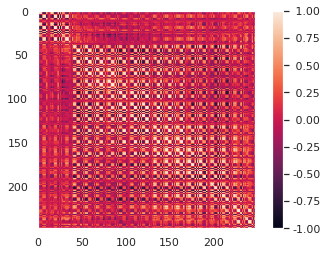

In [539]:
plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()
im = ax.imshow(corr)
im.set_clim(-1, 1)
ax.grid(False)
#ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('x', 'y', 'z'))
#ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('x', 'y', 'z'))
#ax.set_ylim(2.5, -0.5)
#for i in range(3):
#    for j in range(3):
#        ax.text(j, i, corr[i, j], ha='center', va='center',
#                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()


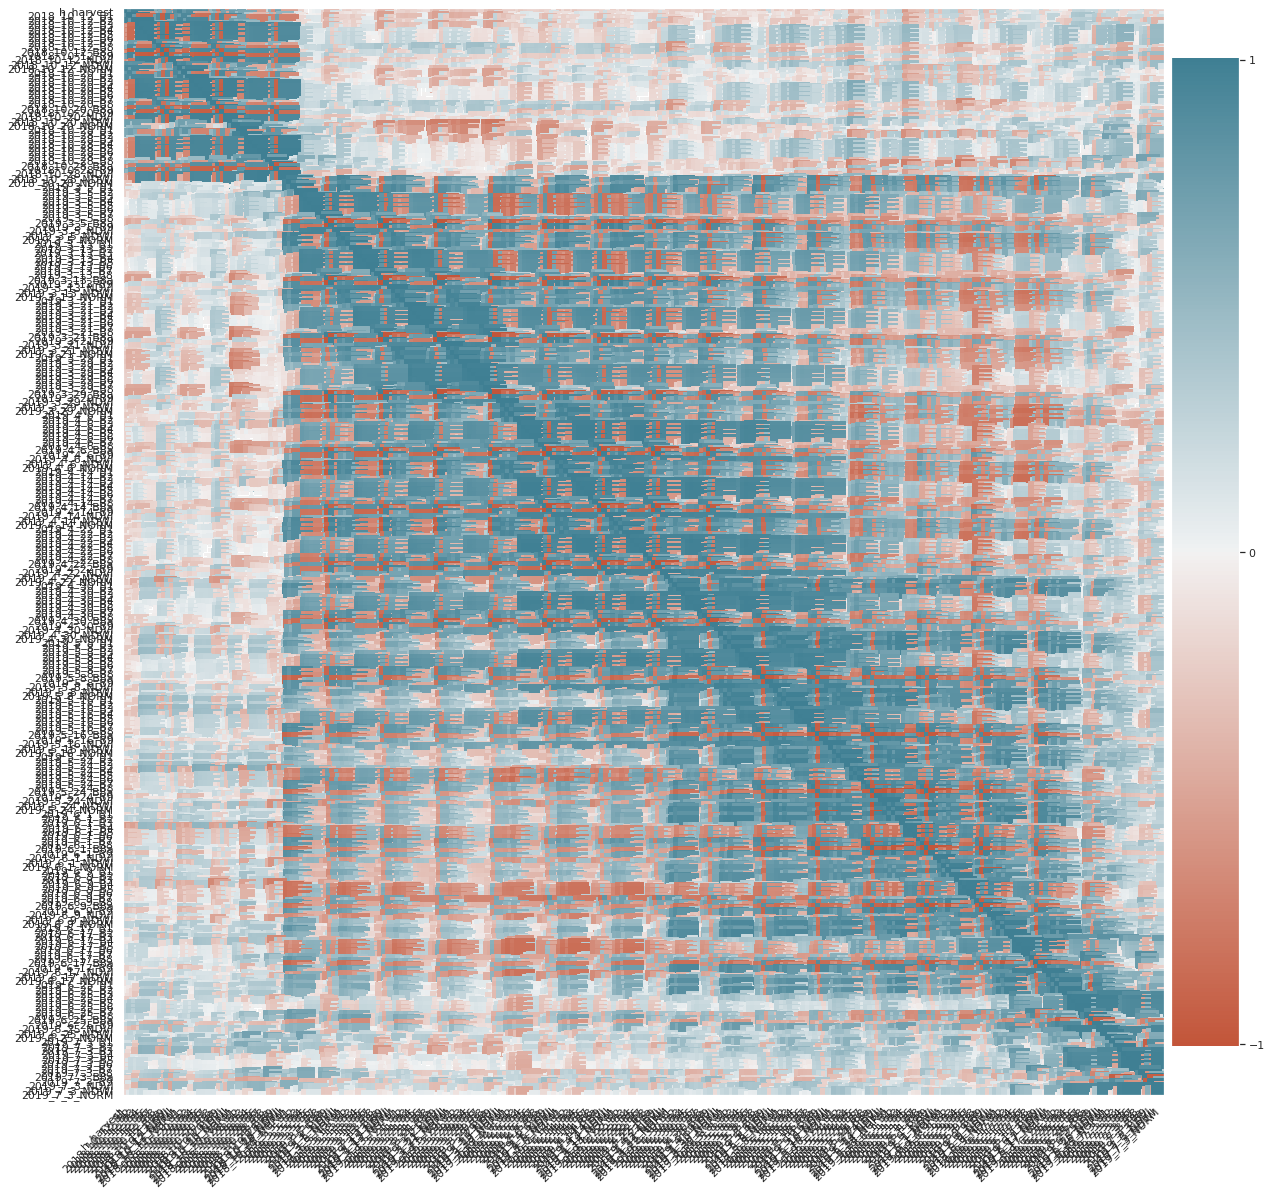

In [541]:
plt.figure(figsize=(20, 20))
corrplot(corr)

# The input vector is ready - let's start predicting Harvest now

#### First import libraries for decision tree models

In [15]:
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install pyforest


In [205]:
# All the import functions in imports.ipynb
from ipynb.fs.full.impdt import *

%run -i impdt.ipynb

In [207]:
# Remove water percentage column as well. Only predict harvest column
#invecdf = invecdf.drop(columns=["h_water_percentage"])
#invecdf = invecdf.drop(columns=["w_precipitation"])

In [542]:
invecdf.shape

(2509, 248)

In [543]:
#keeps the last rows for testing!
test_invecdf = invecdf.iloc[2000:,:]
invecdf = invecdf.iloc[:2000,:]

In [544]:
test_invecdf

h_harvest  2018_10_12_B1  2018_10_12_B2  2018_10_12_B3  2018_10_12_B4  \
2180      11.36           0.05           0.08           0.08           0.12   
2181      10.19           0.05           0.08           0.08           0.12   
2182      11.26           0.05           0.08           0.06           0.12   
2183      10.25           0.05           0.08           0.08           0.12   
2184      10.91           0.05           0.08           0.07           0.12   
...         ...            ...            ...            ...            ...   
2815      12.16           0.05           0.08           0.06           0.12   
2816      12.16           0.05           0.08           0.06           0.12   
2817      12.14           0.05           0.08           0.06           0.12   
2818      12.14           0.05           0.08           0.06           0.12   
2819      11.90           0.05           0.08           0.06           0.12   

      2018_10_12_B5  2018_10_12_B6  2018_10_12_B7  2018_10_12_B8  \
2180           0.20           0.22           0.23           0.24   
2181           0.20           0.23           0.23           0.24   
2182           0.28           0.32           0.32           0.33   
2183           0.20           0.22           0.23           0.24   
2184           0.28           0.32           0.32           0.34   
...             ...            ...            ...            ...   
2815           0.29           0.33           0.33           0.35   
2816           0.29           0.33           0.34           0.35   
2817           0.30           0.34           0.34           0.35   
2818           0.30           0.34           0.34           0.35   
2819           0.29           0.33           0.34           0.35   

      2018_10_12_B8a  ...  2019_7_3_B4  2019_7_3_B5  2019_7_3_B6  2019_7_3_B7  \
2180            0.20  ...         0.11         0.27         0.35         0.36   
2181            0.20  ...         0.11         0.27         0.35         0.36   
2182            0.18  ...         0.13         0.28         0.35         0.37   
2183            0.20  ...         0.11         0.27         0.35         0.36   
2184            0.18  ...         0.13         0.29         0.36         0.37   
...              ...  ...          ...          ...          ...          ...   
2815            0.17  ...         0.13         0.27         0.32         0.33   
2816            0.17  ...         0.13         0.27         0.32         0.33   
2817            0.17  ...         0.13         0.27         0.32         0.33   
2818            0.17  ...         0.13         0.27         0.32         0.33   
2819            0.17  ...         0.13         0.27         0.32         0.33   

      2019_7_3_B8  2019_7_3_B8a  2019_7_3_B9  2019_7_3_NDVI  2019_7_3_NDWI  \
2180         0.38          0.16         0.09           0.72          -0.68   
2181         0.38          0.16         0.09           0.72          -0.68   
2182         0.38          0.16         0.09           0.69          -0.66   
2183         0.38          0.16         0.09           0.72          -0.68   
2184         0.39          0.16         0.09           0.69          -0.66   
...           ...           ...          ...            ...            ...   
2815         0.34          0.18         0.11           0.60          -0.57   
2816         0.34          0.18         0.11           0.61          -0.58   
2817         0.34          0.17         0.11           0.62          -0.58   
2818         0.34          0.18         0.11           0.62          -0.58   
2819         0.34          0.18         0.11           0.61          -0.58   

      2019_7_3_NORM  
2180           0.73  
2181           0.74  
2182           0.75  
2183           0.74  
2184           0.76  
...             ...  
2815           0.70  
2816           0.70  
2817           0.71  
2818           0.71  
2819           0.70  

[509 rows x 248 columns]

## Note! Removing half the data below 

Attention: Removing halv the data below!!!

In [855]:


# invecdf = invecdf.iloc[::2,:]
# invecdf

## Note! This is doubling the data below!!!! 

In [348]:
#invecdf = pd.concat([invecdf, invecdf],ignore_index=True)

In [545]:
nnfielddfNC = invecdf.copy() # just change name to something else
nnfielddfNC.shape

(2000, 248)

In [546]:
# Creating train test split
X = nnfielddfNC.drop(['h_harvest'],axis=1) # train#df.drop(columns=['label'])
y = nnfielddfNC['h_harvest'] # target#df.label

In [228]:
#X.columns=["F"+str(i) for i in range(0, 260)]

In [226]:
nnfielddfNC = nnfielddfNC.dropna(axis=0)
nnfielddfNC.shape

(2000, 261)

In [212]:
#type(X)

In [351]:
#from sklearn.metrics import mean_squared_error
#X, y  = nnfielddfNC.drop(['harvest'],axis=1), nnfielddfNC['harvest']

In [547]:
# Creating train test split
#X = nnfielddfNC.drop(['h_harvest'],axis=1) # train#df.drop(columns=['label'])
#y = nnfielddfNC['h_harvest'] # target#df.label

        
# Call train_test_split on the data and capture the results
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None,test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [548]:
labels_train = y_train
features_train = X_train
features_test = X_test
labels_test = y_test
new_labels_test = labels_test.astype(int).astype('category')
new_labels_train = labels_train.astype(int).astype('category')

In [549]:
%%time

# Set up training classes
labels_unique = np.unique(new_labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss',
    random_state=42
)

# Train the model
model.fit(features_train, new_labels_train)

<IPython.core.display.Javascript object>

CPU times: user 6min 39s, sys: 948 ms, total: 6min 40s
Wall time: 7.41 s


LGBMClassifier(metric='multi_logloss', num_class=13, objective='multiclass',
               random_state=42)

In [308]:
# Save the model
import joblib
joblib.dump(model, os.path.join('Aug_22_model_SI_LULC.pkl'))

['Aug_22_model_SI_LULC.pkl']

In [550]:
#model_path = os.path.join('Aug_22_model_SI_LULC.pkl')
#model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

In [551]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(new_labels_test, predicted_labels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(new_labels_test, predicted_labels_test, average='weighted')))

Classification accuracy 82.0%
Classification F1-score 81.9%


In [552]:
class_labels

array([ 6,  7,  8,  9, 10, 11, 12, 13, 18])

In [553]:
[idx for idx in class_labels] #[idx for idx in class_labels]
#print(idx)

[6, 7, 8, 9, 10, 11, 12, 13, 18]

In [555]:
class_labels = np.unique(new_labels_test)
class_names = [str(l)+" units" for l in (new_labels_train).unique()]#[lulc_type.name for lulc_type in LULC]
mask = np.in1d(predicted_labels_test, new_labels_test)
predictions = predicted_labels_test[mask]
true_labels = new_labels_test[mask]

In [556]:
# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average='weighted')
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print('Classification accuracy {:.1f}%'.format(100 * accuracy))
print('Classification F1-score {:.1f}%'.format(100 * avg_f1_score))
print()
print('          Class (Harvest value) =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx-6] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print('         * {0:20s} = {1:3.1f}  |  {2:3.1f}  |  {3:3.1f}'.format(*line_data))

Classification accuracy 82.0%
Classification F1-score 81.9%

          Class (Harvest value) =  F1  | Recall | Precision
         --------------------------------------------------
         * 10 units             = 50.0  |  33.3  |  100.0
         * 6 units              = 85.0  |  89.5  |  81.0
         * 8 units              = 75.7  |  75.0  |  76.4
         * 11 units             = 81.1  |  80.2  |  81.9
         * 9 units              = 84.6  |  84.6  |  84.6
         * 14 units             = 84.0  |  86.4  |  81.8
         * 12 units             = 80.0  |  73.2  |  88.2
         * 7 units              = 80.0  |  88.9  |  72.7
         * 15 units             = 100.0  |  100.0  |  100.0
         * 16 units             = 100.0  |  100.0  |  100.0
         * 13 units             = 57.1  |  100.0  |  40.0
         * 18 units             = 100.0  |  100.0  |  100.0


In [557]:
# Define the plotting function
def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = (confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps)
        confusion_matrix = confusion_matrix.astype('float') / normalisation_factor

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    threshold = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)



In [558]:
import itertools

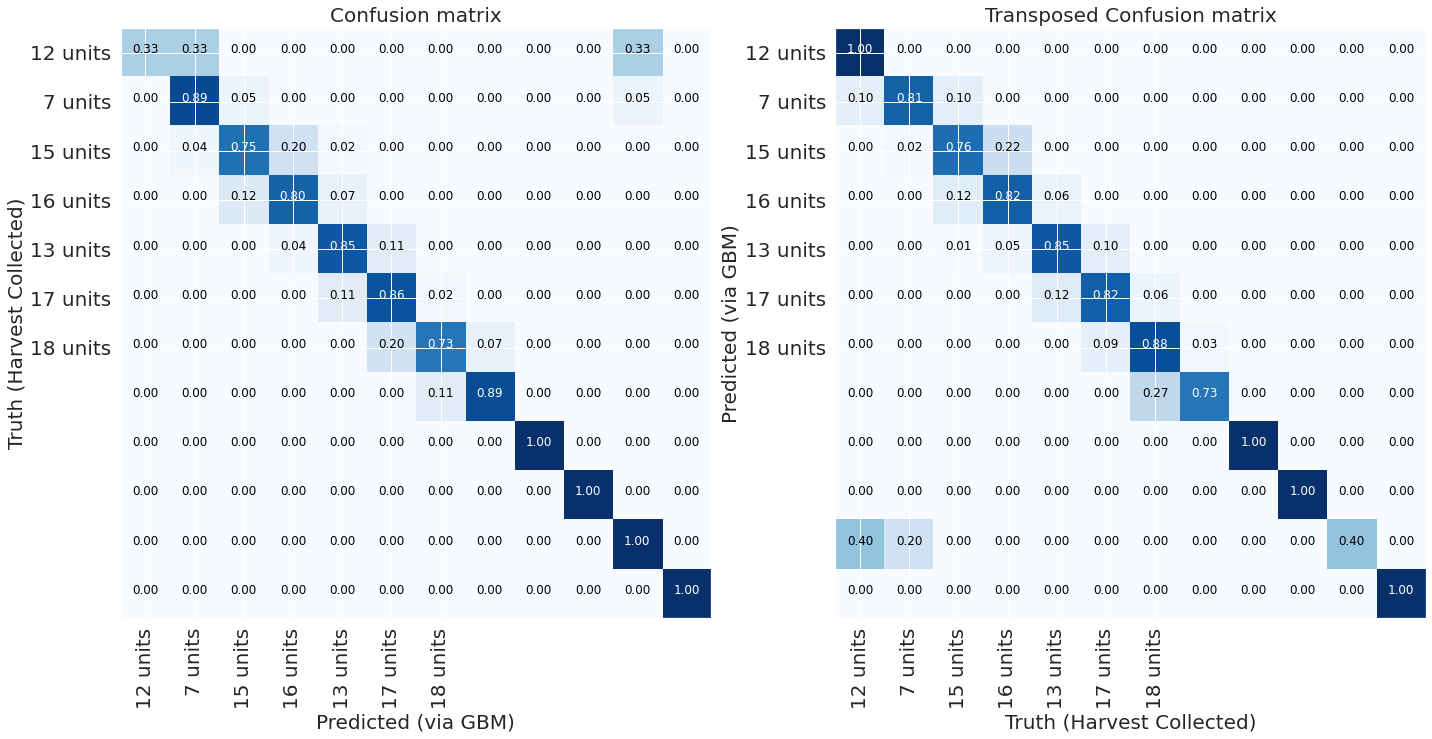

In [559]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = metrics.confusion_matrix(true_labels, predictions)
plot_confusion_matrix(confusion_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (Harvest Collected)',
                      xlabel='Predicted (via GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
plot_confusion_matrix(confusion_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      xlabel='Truth (Harvest Collected)',
                      ylabel='Predicted (via GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()



(array([10.,  8., 14., 31., 47., 49., 48., 77., 79., 66., 38., 16.,  7.,
         5.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 6.73,  7.24,  7.75,  8.25,  8.76,  9.27,  9.77, 10.28, 10.78,
        11.29, 11.8 , 12.3 , 12.81, 13.32, 13.82, 14.33, 14.84, 15.34,
        15.85, 16.35, 16.86, 17.37, 17.87, 18.38, 18.89]),
 <BarContainer object of 24 artists>)

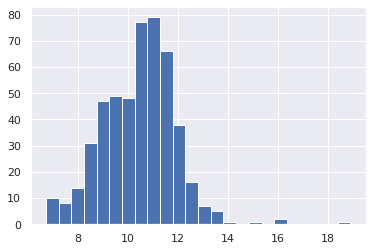

In [560]:
plt.hist(y_test, bins='auto')

(array([  2.,   8.,  13.,  17.,  27.,  38.,  49.,  69.,  71.,  98., 109.,
        120., 134., 148., 132., 135., 102.,  81.,  61.,  39.,  16.,  10.,
          4.,   0.,   3.,   0.,   1.,   2.,   1.,   0.,   6.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   1.]),
 array([ 6.41,  6.73,  7.04,  7.36,  7.68,  8.  ,  8.32,  8.64,  8.95,
         9.27,  9.59,  9.91, 10.23, 10.55, 10.87, 11.18, 11.5 , 11.82,
        12.14, 12.46, 12.78, 13.09, 13.41, 13.73, 14.05, 14.37, 14.69,
        15.01, 15.32, 15.64, 15.96, 16.28, 16.6 , 16.92, 17.23, 17.55,
        17.87, 18.19, 18.51, 18.83]),
 <BarContainer object of 39 artists>)

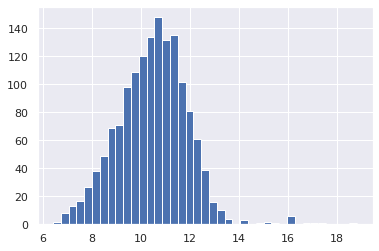

In [561]:
plt.hist(y_train, bins='auto')

In [565]:
# Histogram-based Gradient Boosting Regression Tree

#hist = XGBRegressor() # See fold below for how to properly implement: i.e. change X_train y_train
#hist = LGBMRegressor()
#hist = HistGradientBoostingRegressor() # This worked. With 7 missclassified out of 42
#hist = RandomForestRegressor() # This worked. With 0 missclassified out of 42
#hist = AdaBoostRegressor()
hist = ExtraTreesRegressor()
#hist = GradientBoostingRegressor()
#hist = BaggingRegressor()
#hist = LinearRegression()
#hist = DecisionTreeRegressor()

hist.fit(X_train, y_train)
y_pred = hist.predict(X_test)

In [566]:
rmse(hist,y_test,y_pred,X_train,y_train)

R-squared: 0.9124121227211233
Mean Squared Error: 0.4381750845220289


In [567]:
sumcorrect=0
sumincorrect=0
for k in tqdm(range(len(X_test))):
    row = [X_test.iloc[k,:]]
    trueres = y_test.iloc[k]
    predres = hist.predict(row)
    if abs(trueres-predres) < 0.9: #
    #if trueres==predres:
        sumcorrect += 1 
    else:
        sumincorrect += 1        
print("Correct: ",sumcorrect,". Incorrect: ",sumincorrect)
print("missclassification rate = ", (sumincorrect)/(sumcorrect+sumincorrect))

100% 500/500 [00:04<00:00, 109.65it/s]

Correct:  489 . Incorrect:  11
missclassification rate =  0.022


In [568]:
#row = [[4.4, 0.0, 6.6, 260,  3, 3, 7.3, 9.9, 6.5, 18, 2.3]]
#row=test_invecdf.iloc[1,:]#[X_test.iloc[3,:]]
XX = test_invecdf.drop(['h_harvest'],axis=1) # train#df.drop(columns=['label'])
yy = test_invecdf['h_harvest'] # target#df.label
#XX
#print(row)
#hist.predict(row)

In [570]:
sumcorrect=0
sumincorrect=0
sum_abs = 0.0
for k in tqdm(range(len(XX))):
    row = [XX.iloc[k,:]]
    trueres = yy.iloc[k]
    predres = hist.predict(row)
    print("true:", trueres, ". PRedicted: ",predres)
    sum_abs += abs(trueres-predres)
    if abs(trueres-predres) < .9: #if trueres==predres:
        sumcorrect += 1 
    else:
        sumincorrect += 1        
print("Correct: ",sumcorrect,". Incorrect: ",sumincorrect)
print("missclassification rate = ", (sumincorrect)/(sumcorrect+sumincorrect))
print(sum_abs)

  3% 14/509 [00:00<00:07, 66.15it/s]

true: 11.360522273425506 . PRedicted:  [11.62]
true: 10.186023294509159 . PRedicted:  [10.52]
true: 11.257571801566574 . PRedicted:  [10.71]
true: 10.253846153846164 . PRedicted:  [10.59]
true: 10.907223476297972 . PRedicted:  [10.74]
true: 12.136101083032482 . PRedicted:  [11.63]
true: 10.606879606879607 . PRedicted:  [10.49]
true: 11.401627218934914 . PRedicted:  [10.72]
true: 11.202204724409443 . PRedicted:  [10.73]
true: 11.181404174573055 . PRedicted:  [11.52]
true: 11.623291492329159 . PRedicted:  [11.93]
true: 11.416693944353511 . PRedicted:  [10.77]
true: 10.65058411214952 . PRedicted:  [10.49]
true: 11.309594095940955 . PRedicted:  [11.26]


  6% 29/509 [00:00<00:06, 69.36it/s]

true: 11.328431372549009 . PRedicted:  [10.63]
true: 10.370512820512825 . PRedicted:  [10.52]
true: 11.650654450261776 . PRedicted:  [10.76]
true: 11.967664670658687 . PRedicted:  [11.36]
true: 11.569677419354829 . PRedicted:  [10.94]
true: 12.174523809523821 . PRedicted:  [12.11]
true: 10.345945945945955 . PRedicted:  [10.87]
true: 11.701000000000011 . PRedicted:  [12.02]
true: 11.02223796033995 . PRedicted:  [11.21]
true: 11.878496240601494 . PRedicted:  [11.06]
true: 10.816617647058814 . PRedicted:  [10.65]
true: 11.639974293059117 . PRedicted:  [10.7]
true: 11.627719298245612 . PRedicted:  [10.65]
true: 12.072929542645243 . PRedicted:  [10.72]
true: 11.512515337423311 . PRedicted:  [10.77]


  9% 48/509 [00:00<00:05, 80.37it/s]

true: 12.095910290237459 . PRedicted:  [10.89]
true: 10.463917525773189 . PRedicted:  [10.82]
true: 12.196725440806041 . PRedicted:  [10.77]
true: 10.912989045383418 . PRedicted:  [11.18]
true: 10.550499286733247 . PRedicted:  [11.06]
true: 11.801997896950583 . PRedicted:  [10.56]
true: 10.448911465892602 . PRedicted:  [10.86]
true: 10.819142857142849 . PRedicted:  [10.84]
true: 12.333672316384165 . PRedicted:  [10.89]
true: 10.867950693374429 . PRedicted:  [11.18]
true: 10.868143459915611 . PRedicted:  [11.83]
true: 10.36490939044481 . PRedicted:  [10.8]
true: 12.4775 . PRedicted:  [11.71]
true: 9.893885601577905 . PRedicted:  [10.76]
true: 10.715643274853797 . PRedicted:  [10.83]
true: 11.486822660098523 . PRedicted:  [10.82]
true: 12.57189409368635 . PRedicted:  [10.61]
true: 10.58449367088608 . PRedicted:  [10.83]
true: 11.274373259052927 . PRedicted:  [10.76]


 11% 58/509 [00:00<00:05, 84.10it/s]

true: 11.970866141732287 . PRedicted:  [10.77]
true: 11.583286118980174 . PRedicted:  [11.71]
true: 12.150512295081965 . PRedicted:  [10.4]
true: 11.315191740412985 . PRedicted:  [10.87]
true: 12.807074973600836 . PRedicted:  [10.38]
true: 12.308854781582049 . PRedicted:  [11.64]
true: 10.94331641285956 . PRedicted:  [10.84]
true: 11.61719242902208 . PRedicted:  [11.71]
true: 11.414025500910743 . PRedicted:  [11.72]
true: 13.051360174102287 . PRedicted:  [10.31]
true: 10.64846743295019 . PRedicted:  [10.8]
true: 12.982962138084641 . PRedicted:  [10.22]
true: 11.549551166965882 . PRedicted:  [10.57]
true: 10.179909706546278 . PRedicted:  [10.8]
true: 10.627526881720428 . PRedicted:  [10.75]
true: 12.22586412395709 . PRedicted:  [11.51]
true: 12.067185289957564 . PRedicted:  [11.56]
true: 12.070906200317955 . PRedicted:  [11.39]
true: 11.764489795918362 . PRedicted:  [11.23]


 15% 78/509 [00:00<00:04, 87.86it/s]

true: 12.203756476683946 . PRedicted:  [11.16]
true: 9.96558139534884 . PRedicted:  [10.35]
true: 10.168145161290319 . PRedicted:  [10.41]
true: 10.123044397462998 . PRedicted:  [10.33]
true: 11.13688212927755 . PRedicted:  [10.39]
true: 10.233990147783258 . PRedicted:  [10.33]
true: 11.492730844793707 . PRedicted:  [10.31]
true: 10.26079812206574 . PRedicted:  [10.34]
true: 10.757824427480923 . PRedicted:  [10.34]
true: 12.091851851851859 . PRedicted:  [10.32]
true: 12.34260089686099 . PRedicted:  [10.29]
true: 12.62310704960836 . PRedicted:  [10.29]
true: 10.864644714038135 . PRedicted:  [10.32]
true: 10.889127105666164 . PRedicted:  [10.31]
true: 11.012531645569634 . PRedicted:  [10.38]
true: 10.556293706293705 . PRedicted:  [10.31]
true: 10.498823529411768 . PRedicted:  [10.31]
true: 12.907279693486608 . PRedicted:  [12.35]
true: 10.861822985468963 . PRedicted:  [10.33]


 19% 97/509 [00:01<00:04, 88.73it/s]

true: 13.25107458912769 . PRedicted:  [10.39]
true: 10.997601918465236 . PRedicted:  [10.34]
true: 11.91363636363637 . PRedicted:  [12.59]
true: 12.901836158192083 . PRedicted:  [10.36]
true: 12.538761467889909 . PRedicted:  [12.59]
true: 13.233160621761655 . PRedicted:  [10.4]
true: 12.551338944146902 . PRedicted:  [12.59]
true: 12.117161016949153 . PRedicted:  [10.42]
true: 10.85662878787879 . PRedicted:  [10.36]
true: 12.380978689818475 . PRedicted:  [12.74]
true: 12.601684532924953 . PRedicted:  [10.41]
true: 11.645563139931753 . PRedicted:  [12.76]
true: 10.711745513866234 . PRedicted:  [10.31]
true: 12.017809364548512 . PRedicted:  [12.95]
true: 12.592361111111115 . PRedicted:  [12.78]
true: 13.132679738562105 . PRedicted:  [12.54]
true: 10.820664206642062 . PRedicted:  [10.29]
true: 12.52296238244516 . PRedicted:  [12.98]
true: 12.710474006116216 . PRedicted:  [12.96]


 23% 115/509 [00:01<00:04, 88.88it/s]

true: 12.683627978478105 . PRedicted:  [12.98]
true: 12.94107692307693 . PRedicted:  [12.96]
true: 12.677743431221037 . PRedicted:  [13.03]
true: 10.112274368231038 . PRedicted:  [10.23]
true: 12.69307692307694 . PRedicted:  [13.05]
true: 12.899348958333334 . PRedicted:  [10.51]
true: 12.669837587006974 . PRedicted:  [13.03]
true: 11.078141135972457 . PRedicted:  [13.14]
true: 12.859423676012472 . PRedicted:  [13.12]
true: 12.323825503355728 . PRedicted:  [13.06]
true: 12.788547271329756 . PRedicted:  [13.12]
true: 13.497709923664111 . PRedicted:  [10.51]
true: 12.726237234878257 . PRedicted:  [13.12]
true: 13.646930946291544 . PRedicted:  [10.51]
true: 13.53100381194408 . PRedicted:  [10.59]
true: 12.871665351223365 . PRedicted:  [13.21]
true: 13.00657118786858 . PRedicted:  [13.21]
true: 12.982451923076926 . PRedicted:  [13.23]


 26% 134/509 [00:01<00:04, 89.54it/s]

true: 11.605967976710339 . PRedicted:  [13.24]
true: 12.585208596713024 . PRedicted:  [10.21]
true: 12.904598597038202 . PRedicted:  [13.18]
true: 12.226897844423616 . PRedicted:  [13.27]
true: 13.542673521850894 . PRedicted:  [10.57]
true: 12.79889415481832 . PRedicted:  [13.23]
true: 11.751876675603205 . PRedicted:  [13.34]
true: 12.631802120141348 . PRedicted:  [12.9]
true: 12.859244689221082 . PRedicted:  [13.29]
true: 12.14108606557378 . PRedicted:  [13.19]
true: 13.370063694267511 . PRedicted:  [10.32]
true: 12.999056603773576 . PRedicted:  [13.29]
true: 12.860929648241212 . PRedicted:  [10.16]
true: 13.371410256410257 . PRedicted:  [10.36]
true: 12.86329617834396 . PRedicted:  [13.26]
true: 12.859855769230759 . PRedicted:  [13.29]
true: 12.121470588235288 . PRedicted:  [13.17]
true: 12.877554744525535 . PRedicted:  [13.24]
true: 12.97070063694267 . PRedicted:  [13.24]


 30% 153/509 [00:01<00:03, 89.72it/s]

true: 12.866156325543894 . PRedicted:  [13.28]
true: 12.29708994708995 . PRedicted:  [9.95]
true: 11.896033994334283 . PRedicted:  [13.18]
true: 12.776777777777774 . PRedicted:  [12.93]
true: 12.67728310502282 . PRedicted:  [13.14]
true: 12.430718954248361 . PRedicted:  [9.85]
true: 12.797595356550568 . PRedicted:  [13.34]
true: 12.969338422391855 . PRedicted:  [10.34]
true: 12.844213886671975 . PRedicted:  [13.24]
true: 11.566261398176286 . PRedicted:  [9.96]
true: 12.580177890724265 . PRedicted:  [13.21]
true: 12.394010416666658 . PRedicted:  [9.89]
true: 14.030440097799495 . PRedicted:  [10.4]
true: 11.914225352112672 . PRedicted:  [13.19]
true: 12.400277264325323 . PRedicted:  [13.24]
true: 11.123251028806576 . PRedicted:  [10.13]
true: 12.62597835137385 . PRedicted:  [13.33]
true: 12.59686774941995 . PRedicted:  [13.32]
true: 12.73037156704361 . PRedicted:  [13.22]


 34% 172/509 [00:02<00:03, 90.16it/s]

true: 12.4436061381074 . PRedicted:  [10.16]
true: 12.60236734693877 . PRedicted:  [13.22]
true: 11.75381294964028 . PRedicted:  [9.81]
true: 12.482324455205813 . PRedicted:  [13.27]
true: 12.386549165120597 . PRedicted:  [13.24]
true: 11.909116022099436 . PRedicted:  [9.88]
true: 12.031141439205962 . PRedicted:  [13.19]
true: 12.164738598442712 . PRedicted:  [13.19]
true: 11.98073394495411 . PRedicted:  [10.06]
true: 12.630000000000006 . PRedicted:  [13.22]
true: 12.067658349328223 . PRedicted:  [13.37]
true: 12.561120840630478 . PRedicted:  [13.17]
true: 12.5012355848435 . PRedicted:  [13.32]
true: 11.681598793363495 . PRedicted:  [9.88]
true: 11.818875502008007 . PRedicted:  [10.11]
true: 11.924297752808982 . PRedicted:  [13.18]
true: 11.749056603773584 . PRedicted:  [9.89]
true: 12.159077380952384 . PRedicted:  [13.44]
true: 12.374161490683235 . PRedicted:  [13.43]


 38% 192/509 [00:02<00:03, 90.13it/s]

true: 11.624620060790269 . PRedicted:  [9.93]
true: 11.542793462109945 . PRedicted:  [10.11]
true: 11.440252707581225 . PRedicted:  [9.97]
true: 12.544483362521902 . PRedicted:  [13.17]
true: 13.080718954248361 . PRedicted:  [10.29]
true: 12.932925472747508 . PRedicted:  [13.43]
true: 11.942048780487811 . PRedicted:  [13.38]
true: 11.095151515151523 . PRedicted:  [13.42]
true: 12.352470588235306 . PRedicted:  [13.48]
true: 11.139368421052634 . PRedicted:  [10.18]
true: 12.933258173618961 . PRedicted:  [13.41]
true: 10.974363992172213 . PRedicted:  [9.96]
true: 13.009233176838812 . PRedicted:  [13.54]
true: 10.901405152224836 . PRedicted:  [10.18]
true: 12.205105438401763 . PRedicted:  [13.12]
true: 12.1979617834395 . PRedicted:  [13.5]
true: 12.650086355785849 . PRedicted:  [13.12]
true: 12.493039647577103 . PRedicted:  [13.19]
true: 13.07754677754678 . PRedicted:  [13.54]


 42% 212/509 [00:02<00:03, 90.15it/s]

true: 11.940683229813676 . PRedicted:  [13.58]
true: 12.34444444444443 . PRedicted:  [13.02]
true: 12.006732117812058 . PRedicted:  [13.1]
true: 12.100544464609799 . PRedicted:  [13.5]
true: 12.207117008443928 . PRedicted:  [13.51]
true: 11.257844690966715 . PRedicted:  [13.47]
true: 13.137833037300176 . PRedicted:  [13.54]
true: 11.494751381215476 . PRedicted:  [13.5]
true: 13.164403292181072 . PRedicted:  [13.52]
true: 13.03006681514478 . PRedicted:  [13.57]
true: 12.450635593220365 . PRedicted:  [13.52]
true: 11.783010156971379 . PRedicted:  [13.5]
true: 12.22475000000002 . PRedicted:  [13.55]
true: 13.064105378704738 . PRedicted:  [13.57]
true: 12.14277620396601 . PRedicted:  [13.55]
true: 11.68411347517731 . PRedicted:  [13.53]
true: 11.600111234705237 . PRedicted:  [13.53]
true: 11.879749103942647 . PRedicted:  [13.53]
true: 12.492711682743844 . PRedicted:  [13.56]


 45% 231/509 [00:02<00:03, 89.53it/s]

true: 13.224810892586984 . PRedicted:  [13.62]
true: 13.217677642980929 . PRedicted:  [13.62]
true: 12.333935483870967 . PRedicted:  [13.56]
true: 13.092316017316014 . PRedicted:  [13.69]
true: 12.146622734761117 . PRedicted:  [13.68]
true: 13.242668269230759 . PRedicted:  [13.62]
true: 12.521151586368982 . PRedicted:  [13.56]
true: 13.291852678571406 . PRedicted:  [13.69]
true: 13.32106164383561 . PRedicted:  [13.61]
true: 11.739709443099276 . PRedicted:  [13.53]
true: 13.346286472148533 . PRedicted:  [13.61]
true: 13.363817097415502 . PRedicted:  [13.62]
true: 12.134538878842678 . PRedicted:  [13.68]
true: 13.444237288135588 . PRedicted:  [13.64]
true: 12.40556038227628 . PRedicted:  [13.52]
true: 12.506088082901556 . PRedicted:  [13.71]
true: 13.442074074074057 . PRedicted:  [13.64]
true: 12.68908108108108 . PRedicted:  [13.84]
true: 11.814107142857148 . PRedicted:  [13.57]


 49% 250/509 [00:02<00:02, 89.95it/s]

true: 13.482298546895628 . PRedicted:  [13.64]
true: 13.535476190476173 . PRedicted:  [13.75]
true: 12.318485121731287 . PRedicted:  [13.52]
true: 12.068953068592053 . PRedicted:  [13.71]
true: 12.901051524710821 . PRedicted:  [13.84]
true: 12.075292397660816 . PRedicted:  [13.52]
true: 11.943346379647759 . PRedicted:  [13.52]
true: 13.450905432595569 . PRedicted:  [13.7]
true: 13.454691689008026 . PRedicted:  [13.75]
true: 13.47779690189328 . PRedicted:  [13.75]
true: 12.048567335243542 . PRedicted:  [13.71]
true: 11.889122137404575 . PRedicted:  [13.52]
true: 13.174230330672728 . PRedicted:  [13.81]
true: 12.158129175946529 . PRedicted:  [13.84]
true: 13.43647540983607 . PRedicted:  [13.82]
true: 13.023399014778317 . PRedicted:  [13.82]
true: 11.275583203732491 . PRedicted:  [13.66]
true: 11.450491400491394 . PRedicted:  [13.73]
true: 11.678439869989159 . PRedicted:  [13.73]


 53% 269/509 [00:03<00:02, 90.33it/s]

true: 11.354973118279558 . PRedicted:  [13.67]
true: 11.22931297709923 . PRedicted:  [13.67]
true: 11.422320302648167 . PRedicted:  [13.73]
true: 11.523815165876778 . PRedicted:  [13.73]
true: 11.091681415929203 . PRedicted:  [13.67]
true: 12.133372921615216 . PRedicted:  [13.81]
true: 11.178595317725753 . PRedicted:  [13.67]
true: 10.888100208768268 . PRedicted:  [13.67]
true: 11.050092421441775 . PRedicted:  [13.67]
true: 11.1733660130719 . PRedicted:  [13.67]
true: 10.990253411306043 . PRedicted:  [13.67]
true: 10.902505219206684 . PRedicted:  [13.67]
true: 11.101121794871803 . PRedicted:  [13.69]
true: 12.06374745417516 . PRedicted:  [13.75]
true: 11.599198396793597 . PRedicted:  [13.75]
true: 11.724040920716106 . PRedicted:  [13.75]
true: 10.891052631578951 . PRedicted:  [13.63]
true: 11.244515103338637 . PRedicted:  [13.76]
true: 11.195319148936175 . PRedicted:  [13.74]


 57% 289/509 [00:03<00:02, 90.46it/s]

true: 11.876559546313814 . PRedicted:  [13.73]
true: 11.015570934256061 . PRedicted:  [13.84]
true: 12.12859813084113 . PRedicted:  [13.64]
true: 11.513843351548282 . PRedicted:  [13.85]
true: 10.899812734082404 . PRedicted:  [13.83]
true: 10.745278969957091 . PRedicted:  [13.83]
true: 12.090552325581404 . PRedicted:  [13.67]
true: 10.642271293375398 . PRedicted:  [13.83]
true: 11.504397163120577 . PRedicted:  [13.76]
true: 12.102666666666668 . PRedicted:  [13.67]
true: 10.320156555772995 . PRedicted:  [13.74]
true: 10.632268370607031 . PRedicted:  [13.83]
true: 10.401675977653628 . PRedicted:  [13.74]
true: 12.074036850921269 . PRedicted:  [13.6]
true: 11.335653235653233 . PRedicted:  [13.79]
true: 10.396712802768162 . PRedicted:  [13.74]
true: 10.882889733840305 . PRedicted:  [13.78]
true: 10.61893129770992 . PRedicted:  [13.68]
true: 12.007307692307698 . PRedicted:  [13.6]


 61% 309/509 [00:03<00:02, 90.17it/s]

true: 11.701512287334591 . PRedicted:  [13.79]
true: 12.002614379084966 . PRedicted:  [13.6]
true: 10.571428571428564 . PRedicted:  [13.67]
true: 11.67806451612902 . PRedicted:  [13.76]
true: 11.072097378277137 . PRedicted:  [13.77]
true: 10.895070422535204 . PRedicted:  [13.66]
true: 10.754864864864867 . PRedicted:  [13.66]
true: 10.674566473988445 . PRedicted:  [13.66]
true: 10.628078817733988 . PRedicted:  [9.08]
true: 11.024444444444432 . PRedicted:  [9.06]
true: 10.680198019801972 . PRedicted:  [9.09]
true: 10.259183673469385 . PRedicted:  [9.17]
true: 10.7896860986547 . PRedicted:  [9.13]
true: 9.968805704099818 . PRedicted:  [9.22]
true: 9.547291666666672 . PRedicted:  [9.29]
true: 10.663920454545448 . PRedicted:  [9.14]
true: 10.692258883248732 . PRedicted:  [9.12]
true: 10.554057771664374 . PRedicted:  [9.16]
true: 9.400000000000013 . PRedicted:  [9.8]


 65% 329/509 [00:03<00:01, 90.57it/s]

true: 10.143356643356642 . PRedicted:  [9.25]
true: 9.61694915254238 . PRedicted:  [9.8]
true: 10.899094437257421 . PRedicted:  [9.09]
true: 11.095811518324597 . PRedicted:  [9.12]
true: 10.631772151898728 . PRedicted:  [9.16]
true: 9.656312292358816 . PRedicted:  [9.8]
true: 10.264967320261437 . PRedicted:  [9.26]
true: 9.706782106782116 . PRedicted:  [9.8]
true: 10.144148936170213 . PRedicted:  [9.46]
true: 9.910758620689666 . PRedicted:  [9.9]
true: 11.596583442838378 . PRedicted:  [9.13]
true: 9.883132530120488 . PRedicted:  [9.79]
true: 10.029189189189196 . PRedicted:  [9.81]
true: 10.53964334705076 . PRedicted:  [9.35]
true: 10.263227513227518 . PRedicted:  [9.88]
true: 11.230079155672822 . PRedicted:  [9.16]
true: 10.681841763942938 . PRedicted:  [9.95]
true: 10.69001349527665 . PRedicted:  [9.22]
true: 10.567123287671242 . PRedicted:  [9.37]


 69% 349/509 [00:03<00:01, 90.57it/s]

true: 10.562381596752369 . PRedicted:  [9.29]
true: 10.476551724137934 . PRedicted:  [9.6]
true: 10.364730290456436 . PRedicted:  [9.65]
true: 10.555906593406595 . PRedicted:  [9.91]
true: 10.790921409214093 . PRedicted:  [10.07]
true: 10.78686868686869 . PRedicted:  [10.22]
true: 10.47854195323246 . PRedicted:  [9.8]
true: 10.408248914616502 . PRedicted:  [10.18]
true: 10.370684931506855 . PRedicted:  [9.45]
true: 10.156622516556293 . PRedicted:  [10.18]
true: 10.403708791208789 . PRedicted:  [9.19]
true: 12.202793946449376 . PRedicted:  [10.27]
true: 10.761693548387099 . PRedicted:  [10.23]
true: 10.693527080581243 . PRedicted:  [10.29]
true: 10.665807327001353 . PRedicted:  [9.89]
true: 10.339427012278307 . PRedicted:  [9.25]
true: 10.310958904109585 . PRedicted:  [9.27]
true: 10.797169811320757 . PRedicted:  [9.96]
true: 12.246242774566479 . PRedicted:  [10.32]


 72% 369/509 [00:04<00:01, 90.56it/s]

true: 12.103780068728529 . PRedicted:  [10.32]
true: 10.189385474860337 . PRedicted:  [9.26]
true: 12.42277456647399 . PRedicted:  [10.35]
true: 10.922922252010725 . PRedicted:  [10.24]
true: 10.678255033557047 . PRedicted:  [10.37]
true: 10.8243131868132 . PRedicted:  [10.47]
true: 10.102642559109873 . PRedicted:  [9.27]
true: 10.545990922844187 . PRedicted:  [10.45]
true: 10.04179310344827 . PRedicted:  [9.41]
true: 12.37122807017543 . PRedicted:  [10.34]
true: 12.042621015348287 . PRedicted:  [10.36]
true: 10.028257887517144 . PRedicted:  [9.61]
true: 10.190560875512997 . PRedicted:  [9.34]
true: 10.486567164179107 . PRedicted:  [9.8]
true: 10.09157458563536 . PRedicted:  [9.26]
true: 11.804566744730677 . PRedicted:  [10.47]
true: 9.417787418655104 . PRedicted:  [10.53]
true: 11.419275549805947 . PRedicted:  [10.21]
true: 11.457989690721652 . PRedicted:  [10.32]


 76% 389/509 [00:04<00:01, 90.29it/s]

true: 12.293629807692296 . PRedicted:  [10.32]
true: 10.079392971246003 . PRedicted:  [10.54]
true: 11.690095465393803 . PRedicted:  [10.53]
true: 10.746363636363633 . PRedicted:  [10.55]
true: 9.588047808764943 . PRedicted:  [10.42]
true: 11.860978670012559 . PRedicted:  [10.27]
true: 12.099385749385752 . PRedicted:  [10.52]
true: 12.010148514851481 . PRedicted:  [10.43]
true: 10.507432432432429 . PRedicted:  [10.52]
true: 11.346414602346819 . PRedicted:  [9.96]
true: 11.942401960784302 . PRedicted:  [10.52]
true: 11.614619164619159 . PRedicted:  [10.52]
true: 12.009589041095891 . PRedicted:  [10.28]
true: 11.99345679012346 . PRedicted:  [10.28]
true: 11.910050251256274 . PRedicted:  [10.24]
true: 11.566707616707598 . PRedicted:  [10.47]
true: 11.749935979513433 . PRedicted:  [10.45]
true: 10.573111395646597 . PRedicted:  [10.39]
true: 12.02716049382716 . PRedicted:  [10.29]


 78% 399/509 [00:04<00:01, 90.26it/s]

true: 10.422402159244264 . PRedicted:  [10.39]
true: 11.568719806763282 . PRedicted:  [10.36]
true: 11.905742821473162 . PRedicted:  [10.15]
true: 11.783437892095359 . PRedicted:  [10.45]
true: 11.976312576312594 . PRedicted:  [10.32]
true: 11.902767749699166 . PRedicted:  [10.42]
true: 11.883313180169294 . PRedicted:  [10.32]
true: 10.472508038585199 . PRedicted:  [10.36]
true: 11.751616766467066 . PRedicted:  [10.44]
true: 11.776847290640395 . PRedicted:  [10.35]
true: 11.632405063291147 . PRedicted:  [10.37]
true: 11.831421446384056 . PRedicted:  [10.3]
true: 11.885202863961815 . PRedicted:  [10.44]
true: 10.903259452411982 . PRedicted:  [10.36]
true: 10.526394052044601 . PRedicted:  [10.38]
true: 10.859136690647478 . PRedicted:  [10.41]
true: 11.84347826086958 . PRedicted:  [10.34]
true: 11.700000000000012 . PRedicted:  [10.28]
true: 11.273736128236745 . PRedicted:  [10.38]


 82% 419/509 [00:04<00:00, 90.99it/s]

true: 10.791335740072206 . PRedicted:  [10.36]
true: 12.132273838630825 . PRedicted:  [10.45]
true: 11.759085714285709 . PRedicted:  [10.39]
true: 11.595444191343963 . PRedicted:  [10.4]
true: 11.772101910828031 . PRedicted:  [10.29]
true: 11.089399293286222 . PRedicted:  [10.3]
true: 12.038095238095242 . PRedicted:  [10.39]
true: 11.849194547707569 . PRedicted:  [10.38]
true: 11.804326923076928 . PRedicted:  [10.46]
true: 12.1199770378875 . PRedicted:  [10.42]
true: 12.025030674846613 . PRedicted:  [10.34]
true: 12.204328018223233 . PRedicted:  [10.46]
true: 11.94618991793669 . PRedicted:  [10.47]
true: 11.926596980255514 . PRedicted:  [10.51]
true: 12.036363636363635 . PRedicted:  [10.59]
true: 12.247957992998828 . PRedicted:  [10.45]
true: 11.915801614763552 . PRedicted:  [10.52]
true: 11.924457142857134 . PRedicted:  [10.58]
true: 12.195259593679458 . PRedicted:  [10.45]


 86% 439/509 [00:04<00:00, 90.16it/s]

true: 12.17409909909909 . PRedicted:  [10.41]
true: 9.662084257206214 . PRedicted:  [9.67]
true: 12.299525504151836 . PRedicted:  [10.4]
true: 9.580238095238096 . PRedicted:  [9.63]
true: 10.519295558958662 . PRedicted:  [9.71]
true: 12.16517241379311 . PRedicted:  [10.55]
true: 12.218451025056938 . PRedicted:  [10.3]
true: 10.826454293628814 . PRedicted:  [9.98]
true: 11.897069597069578 . PRedicted:  [10.23]
true: 12.394905869324456 . PRedicted:  [10.4]
true: 10.070285714285717 . PRedicted:  [9.69]
true: 12.529078801331831 . PRedicted:  [10.41]
true: 12.338706140350855 . PRedicted:  [10.3]
true: 12.633922996878276 . PRedicted:  [10.58]
true: 11.836418269230746 . PRedicted:  [10.2]
true: 10.386141732283466 . PRedicted:  [9.77]
true: 12.416482300884958 . PRedicted:  [10.55]
true: 12.430490405117279 . PRedicted:  [10.44]
true: 12.337136465324395 . PRedicted:  [10.53]
true:

 90% 458/509 [00:05<00:00, 89.64it/s]

 12.612706611570262 . PRedicted:  [10.58]
true: 13.999601593625483 . PRedicted:  [10.29]
true: 12.620061728395063 . PRedicted:  [10.63]
true: 12.589435146443519 . PRedicted:  [10.58]
true: 12.696941896024477 . PRedicted:  [10.62]
true: 11.463582443653618 . PRedicted:  [10.19]
true: 13.704284323271672 . PRedicted:  [10.29]
true: 10.72954876273653 . PRedicted:  [9.97]
true: 13.823942307692313 . PRedicted:  [10.26]
true: 13.552485089463229 . PRedicted:  [10.23]
true: 11.037780713342135 . PRedicted:  [9.97]
true: 12.6446483180428 . PRedicted:  [10.65]
true: 13.570094339622655 . PRedicted:  [10.26]
true: 12.528021390374331 . PRedicted:  [10.78]
true: 13.612293577981667 . PRedicted:  [10.29]
true: 12.643718079673127 . PRedicted:  [10.68]
true: 10.898680351906155 . PRedicted:  [9.9]
true: 11.427423167848696 . PRedicted:  [10.]
true: 12.681172839506164 . PRedicted:  [10.75]
true: 13.414156079854822 . PRedicted:  [10.23]
true: 11.26156763590391 . PRedicted:  [10.]


 94% 478/509 [00:05<00:00, 90.37it/s]

true: 11.632480533926584 . PRedicted:  [10.17]
true: 12.684244372990348 . PRedicted:  [10.8]
true: 12.677415966386544 . PRedicted:  [10.8]
true: 11.127842565597662 . PRedicted:  [9.88]
true: 12.705888767720824 . PRedicted:  [10.84]
true: 12.67209554831704 . PRedicted:  [10.77]
true: 12.518996798292417 . PRedicted:  [10.75]
true: 13.529590865842067 . PRedicted:  [9.92]
true: 12.62904290429042 . PRedicted:  [10.83]
true: 13.505798394290819 . PRedicted:  [10.09]
true: 13.488362427265173 . PRedicted:  [10.13]
true: 12.363515016685213 . PRedicted:  [10.69]
true: 12.408029978586725 . PRedicted:  [10.54]
true: 11.848109965635745 . PRedicted:  [9.77]
true: 12.52411831626849 . PRedicted:  [10.81]
true: 12.273363949483361 . PRedicted:  [10.67]
true: 12.206952491309394 . PRedicted:  [10.63]
true: 12.416935483870981 . PRedicted:  [10.84]
true: 12.158147713950779 . PRedicted:  [10.68]
true:

 98% 498/509 [00:05<00:00, 90.16it/s]

 12.127100591715987 . PRedicted:  [10.68]
true: 10.899847328244281 . PRedicted:  [9.34]
true: 12.31245714285716 . PRedicted:  [10.23]
true: 12.107065868263481 . PRedicted:  [10.63]
true: 10.79790104947527 . PRedicted:  [9.35]
true: 12.312698412698428 . PRedicted:  [10.14]
true: 12.234074941451999 . PRedicted:  [10.76]
true: 10.05028571428572 . PRedicted:  [9.2]
true: 10.852266288951851 . PRedicted:  [9.26]
true: 12.182567726737346 . PRedicted:  [10.62]
true: 9.899609375000008 . PRedicted:  [9.18]
true: 9.69258426966293 . PRedicted:  [9.14]
true: 12.178365937859612 . PRedicted:  [10.64]
true: 10.531939163498114 . PRedicted:  [9.16]
true: 10.166991643454056 . PRedicted:  [9.17]
true: 9.411968085106391 . PRedicted:  [9.09]
true: 12.104728132387681 . PRedicted:  [9.77]
true: 12.119621749408962 . PRedicted:  [9.98]
true: 12.163837209302304 . PRedicted:  [9.63]


100% 509/509 [00:05<00:00, 88.42it/s]

true: 12.160163551401851 . PRedicted:  [10.1]
true: 12.136847826086948 . PRedicted:  [10.65]
true: 12.141375422773375 . PRedicted:  [10.45]
true: 11.896747967479651 . PRedicted:  [9.51]
Correct:  206 . Incorrect:  303
missclassification rate =  0.5952848722986247
[648.95]


In [571]:
kf = KFold(n_splits =5,shuffle=True,random_state=160)
feats = pd.DataFrame({'features': X.columns}) 
gbm_predictions = []
cv_score_ = 0
oof_preds = np.zeros((nnfielddfNC.shape[0],))

<IPython.core.display.Javascript object>

In [572]:
gbm_score = 0
for i,(tr_index,test_index) in enumerate(kf.split(X,y)):
  
  print(tr_index)
  print(f'######### FOLD {i+1} / {kf.n_splits} ')
  
  #X_train,y_train = X.iloc[tr_index,:],y[tr_index]
  tempX = X.loc[X.index.intersection(tr_index),:]  
  #tempX = X.reindex[tr_index,:]
  tempy = y.loc[y.index.intersection(tr_index)] 
  X_train,y_train = tempX, tempy
  #tips_filtered = tips_df.reindex(columns = filtered_columns).

  #X_test,y_test = X.iloc[test_index,:],y[test_index]
  tempX = X.loc[X.index.intersection(test_index),:] 
  tempy = y.loc[y.index.intersection(test_index)] 
  X_test, y_test = tempX, tempy
  
  #gbm = xgb.ExtraTreesRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)
  gbm = xgb.XGBRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)
  #gbm = xgb.LGBMRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)

  #lgb.LGBMClassifier
  gbm.fit(X_train,y_train,eval_set = [(X_test, y_test)],early_stopping_rounds  = 200,verbose=100)
  gbm_score += gbm.score(X_test, y_test)/ kf.n_splits
  cv_score_ += mean_squared_error(y_test, gbm.predict(X_test), squared=False) / kf.n_splits
  #oof_preds[test_index] = gbm.predict(X_test)
  
  #preds = gbm.predict(nnfielddfNC[X_train.columns])
  #gbm_predictions.append(preds)

  feats[f'Fold {i}'] = gbm.feature_importances_
feats['Importances'] = feats.mean(axis=1)
print('CV RMSE : ', cv_score_)
#preds_xgb = np.average(gbm_predictions, axis=0)
#print(preds_xgb.shape)

[   0    2    3 ... 1996 1997 1998]
######### FOLD 1 / 5 
[0]	validation_0-rmse:9.84711
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.68277
[200]	validation_0-rmse:1.47637
[300]	validation_0-rmse:0.76400
[400]	validation_0-rmse:0.58648
[500]	validation_0-rmse:0.53814
[600]	validation_0-rmse:0.52070
[700]	validation_0-rmse:0.51227
[800]	validation_0-rmse:0.50640
[900]	validation_0-rmse:0.50242
[1000]	validation_0-rmse:0.49940
[1100]	validation_0-rmse:0.49724
[1200]	validation_0-rmse:0.49534
[1300]	validation_0-rmse:0.49377
[1400]	validation_0-rmse:0.49225
[1500]	validation_0-rmse:0.49121
[1600]	validation_0-rmse:0.49023
[1700]	validation_0-rmse:0.48945
[1800]	validation_0-rmse:0.48877
[1900]	validation_0-rmse:0.48808
[1999]	validation_0-rmse:0.48735
[   0    1    2 ... 1996 1997 1999]
######### FOLD 2 / 5 
[0]	validation_0-rmse:9.79364
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.67638
[200]	val

In [573]:
feats['Importances'] = feats.mean(axis=1)
print( ' CV RMSE : ',cv_score_)
preds_xgb = np.average(gbm_predictions, axis=0)
print(preds_xgb.shape)

 CV RMSE :  0.3741330691866717
()


In [574]:
print("Accuracy is :", gbm_score)

Accuracy is : 0.9266027148784792


In [575]:
#preds = gbm.predict(nnfielddfNC[X_train.columns])
preds_new = gbm.predict(test_invecdf[XX.columns])
np.sum(np.abs(preds_new - yy))
#row = XX.iloc[0,:]
#print(row)
#print(y.iloc[0])
#hist.predict(row)

1095.6464329000887

In [576]:
k=33
row = [XX.iloc[k,:]]
trueres = yy.iloc[k]
predres = hist.predict(row)
predgbm = gbm.predict(test_invecdf[XX.columns])[k]#[XX.columns]
print("True:",trueres," Pred 1:", predres, " Pred 2 (gbm):", predgbm)

True: 10.550499286733247  Pred 1: [11.06]  Pred 2 (gbm): 11.440511


In [577]:
feats

features  Fold 0  Fold 1  Fold 2  Fold 3  Fold 4  Importances
0    2018_10_12_B1    0.00    0.00    0.00    0.00    0.00         0.00
1    2018_10_12_B2    0.00    0.00    0.00    0.00    0.00         0.00
2    2018_10_12_B3    0.00    0.00    0.00    0.00    0.00         0.00
3    2018_10_12_B4    0.00    0.00    0.00    0.00    0.00         0.00
4    2018_10_12_B5    0.00    0.00    0.00    0.00    0.00         0.00
..             ...     ...     ...     ...     ...     ...          ...
242   2019_7_3_B8a    0.00    0.00    0.00    0.00    0.00         0.00
243    2019_7_3_B9    0.00    0.00    0.00    0.00    0.00         0.00
244  2019_7_3_NDVI    0.00    0.00    0.00    0.00    0.00         0.00
245  2019_7_3_NDWI    0.00    0.00    0.00    0.00    0.00         0.00
246  2019_7_3_NORM    0.00    0.00    0.00    0.00    0.00         0.00

[247 rows x 7 columns]

In [578]:
# Create dictionary from feats

res = dict(zip(feats["features"], feats["Importances"]))

In [579]:
# Testing
res["s_k"]

KeyError: 's_k'

In [580]:
new_feats = pd.DataFrame(feats).sort_values(by = 'Importances',
                                              ascending = False)
new_feats[:15]

features  Fold 0  Fold 1  Fold 2  Fold 3  Fold 4  Importances
121    2019_4_22_B5    0.19    0.17    0.21    0.13    0.19         0.18
109    2019_4_14_B6    0.06    0.05    0.07    0.06    0.03         0.05
134    2019_4_30_B5    0.02    0.04    0.08    0.05    0.07         0.05
168  2019_5_16_NORM    0.05    0.06    0.03    0.05    0.06         0.05
122    2019_4_22_B6    0.00    0.02    0.09    0.09    0.04         0.05
116  2019_4_14_NORM    0.03    0.06    0.03    0.03    0.05         0.04
129  2019_4_22_NORM    0.06    0.02    0.01    0.03    0.01         0.03
160    2019_5_16_B5    0.03    0.01    0.01    0.02    0.02         0.02
172    2019_5_24_B4    0.01    0.02    0.03    0.01    0.03         0.02
35    2018_10_28_B9    0.02    0.01    0.01    0.02    0.01         0.01
208    2019_6_17_B1    0.02    0.01    0.01    0.01    0.00         0.01
173    2019_5_24_B5    0.01    0.01    0.01    0.01    0.01         0.01
231  2019_6_25_NDVI    0.01    0.01    0.02    0.01    0.01         0.01
157    2019_5_16_B2    0.01    0.02    0.01    0.01    0.01         0.01
8    2018_10_12_B8a    0.01    0.01    0.01    0.01    0.01         0.01

In [581]:
list(new_feats["features"])

['2019_4_22_B5',
 '2019_4_14_B6',
 '2019_4_30_B5',
 '2019_5_16_NORM',
 '2019_4_22_B6',
 '2019_4_14_NORM',
 '2019_4_22_NORM',
 '2019_5_16_B5',
 '2019_5_24_B4',
 '2018_10_28_B9',
 '2019_6_17_B1',
 '2019_5_24_B5',
 '2019_6_25_NDVI',
 '2019_5_16_B2',
 '2018_10_12_B8a',
 '2019_5_24_NDWI',
 '2019_6_25_B1',
 '2019_6_1_NORM',
 '2019_4_22_B8a',
 '2019_4_14_B5',
 '2018_10_20_B3',
 '2019_5_24_B3',
 '2019_6_17_NORM',
 '2019_4_6_B7',
 '2019_6_9_NORM',
 '2019_4_30_B4',
 '2019_3_29_B8a',
 '2019_3_5_B8',
 '2019_6_25_NORM',
 '2019_5_16_B9',
 '2019_4_14_B9',
 '2018_10_28_B5',
 '2019_4_14_NDWI',
 '2019_4_6_B8',
 '2019_4_6_NDVI',
 '2019_5_24_B1',
 '2019_5_8_B8a',
 '2018_10_12_B8',
 '2019_4_6_B8a',
 '2019_6_1_B3',
 '2019_5_16_B3',
 '2019_6_17_B5',
 '2019_3_21_B4',
 '2019_3_5_B8a',
 '2019_6_1_B8',
 '2019_6_17_B3',
 '2019_3_5_B9',
 '2019_5_24_B8a',
 '2019_3_21_B8a',
 '2019_4_14_B3',
 '2019_5_8_B7',
 '2019_4_6_B9',
 '2019_3_29_NDVI',
 '2019_6_17_B6',
 '2019_7_3_B8',
 '2019_5_24_NDVI',
 '2019_6_9_B1',
 '2019_5

In [582]:
#list(new_feats["features"])
list(new_feats["Importances"])


[0.17926429212093353,
 0.05437224730849266,
 0.052302032709121704,
 0.05129237100481987,
 0.04875990375876427,
 0.04015776142477989,
 0.026740001514554024,
 0.016662918031215668,
 0.016453459858894348,
 0.011396494694054127,
 0.010384841822087765,
 0.010095211677253246,
 0.009888063184916973,
 0.009602728299796581,
 0.008915291167795658,
 0.007098333444446325,
 0.006557161454111338,
 0.006538257002830505,
 0.006458332296460867,
 0.006182296201586723,
 0.0061177946627140045,
 0.006012852769345045,
 0.0059197451919317245,
 0.005728248041123152,
 0.005500796716660261,
 0.005462125409394503,
 0.0053895278833806515,
 0.005352701526135206,
 0.005332536995410919,
 0.00524683715775609,
 0.0050442819483578205,
 0.00492515554651618,
 0.004802390933036804,
 0.004761476535350084,
 0.0047163753770291805,
 0.004696203861385584,
 0.004437155555933714,
 0.0043140980415046215,
 0.004171942826360464,
 0.003905808785930276,
 0.0037597145419567823,
 0.0036931063514202833,
 0.003610290354117751,
 0.0035638

In [583]:
accuracy = gbm.score(X_test, y_test)
accuracy

0.9473670002921298

In [584]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

In [585]:
#hist = HistGradientBoostingRegressor() # This worked. With 7 missclassified out of 42
hist = RandomForestRegressor() 

In [586]:
# Instantiate a Random Forest Regressor
regr = HistGradientBoostingRegressor(max_depth=100, random_state=0)
#regr = RandomForestRegressor(max_depth=100, random_state=0)# Fit a random forest regressor
#regr = DecisionTreeRegressor(max_depth=100, random_state=0)
regr.fit(X_train, y_train)

HistGradientBoostingRegressor(max_depth=100, random_state=0)

In [587]:
from sklearn.metrics import mean_squared_error
rmse_full_mod = mean_squared_error(regr.predict(X_test), y_test, squared = False)

In [588]:
# Initialize a list of results
results = []# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(regr.predict(X_test_copy), y_test,
                                  squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod }) # Convert to a pandas dataframe and rank the predictors by score

perm_resultsdf = pd.DataFrame(results)#.sort_values(by = 'score',
                                      #        ascending = False)
# Normalize "score" in per_resultsdf
tot_score = perm_resultsdf["score"].sum()
#print("total score:", tot_score)
#print(perm_resultsdf)
#print(perm_resultsdf.shape)
l = []# empty list
for m in range(len(perm_resultsdf["score"])):
    t = perm_resultsdf.iloc[m,1]/tot_score
    l.append(t)
    #print(m,t)
    #print(perm_resultsdf.iloc[m,2])
    #perm_resultsdf.iloc[m,2] = t
#new_resultsdf = pd.DataFrame()
perm_resultsdf["normalized"] = pd.Series(l)

perm_resultsdf = perm_resultsdf.sort_values(by = 'score',
                                              ascending = False)

In [589]:
perm_resultsdf[:10]

pred  score  normalized
15    2018_10_20_B3   0.33        0.18
121    2019_4_22_B5   0.31        0.17
172    2019_5_24_B4   0.20        0.11
157    2019_5_16_B2   0.11        0.06
235     2019_7_3_B2   0.06        0.03
114  2019_4_14_NDVI   0.05        0.03
35    2018_10_28_B9   0.05        0.03
180  2019_5_24_NDWI   0.05        0.03
1     2018_10_12_B2   0.04        0.02
173    2019_5_24_B5   0.04        0.02

In [590]:
# create a new column in perm_resultsdf containing the feature importance values
new_list = [res[l] for l in perm_resultsdf["pred"]]
#new_list
perm_resultsdf["feat_imp"] = new_list #pd.Series(new_list, ignore_index=True)
#perm_resultsdf["feat_imp"]

In [591]:
list(perm_resultsdf["normalized"])

[0.17828204696110314,
 0.1672174586854868,
 0.10640185110500697,
 0.06180697874230522,
 0.03175544692661053,
 0.029275692832840868,
 0.027603088644125723,
 0.027453348833561868,
 0.023349743478492915,
 0.023174794592790413,
 0.016360285566424,
 0.013478599462566609,
 0.012790210673935471,
 0.012210878225956064,
 0.012163683102782227,
 0.01044323418990428,
 0.009841650401160676,
 0.009812268569898483,
 0.008998126591353236,
 0.00805450590022371,
 0.007768313154655218,
 0.007728405078999028,
 0.0068939480863617645,
 0.006502078811167688,
 0.0063409097683600904,
 0.006107318475787562,
 0.005757617347860772,
 0.0052874013485105275,
 0.005281376365383231,
 0.005089173022908113,
 0.004907432756271965,
 0.0046383489209014086,
 0.004591742173737878,
 0.004572997677663247,
 0.004571722836481211,
 0.004400031784235011,
 0.004375377025346328,
 0.0040625248219849615,
 0.004039756400919978,
 0.0038730642794515217,
 0.0037895702022915896,
 0.0036943474767497405,
 0.0036012505888892263,
 0.0033082744

In [592]:
list(perm_resultsdf["pred"])

['2018_10_20_B3',
 '2019_4_22_B5',
 '2019_5_24_B4',
 '2019_5_16_B2',
 '2019_7_3_B2',
 '2019_4_14_NDVI',
 '2018_10_28_B9',
 '2019_5_24_NDWI',
 '2018_10_12_B2',
 '2019_5_24_B5',
 '2018_10_20_B5',
 '2019_5_8_NORM',
 '2019_4_30_B5',
 '2019_7_3_B4',
 '2019_6_17_NORM',
 '2019_5_8_B7',
 '2018_10_28_B1',
 '2019_6_17_B6',
 '2018_10_12_B8a',
 '2019_3_13_B5',
 '2019_6_9_B1',
 '2019_6_1_B6',
 '2019_3_5_B9',
 '2019_4_30_B6',
 '2019_6_17_B9',
 '2019_3_29_B8a',
 '2019_6_17_B8',
 '2019_4_14_B4',
 '2018_10_12_B9',
 '2018_10_28_B2',
 '2019_6_9_NORM',
 '2018_10_28_B3',
 '2019_6_25_NDVI',
 '2018_10_12_B3',
 '2019_3_5_B2',
 '2019_3_13_B4',
 '2019_4_14_B2',
 '2019_7_3_B1',
 '2019_4_22_NORM',
 '2019_6_17_B3',
 '2019_4_30_B8',
 '2019_5_8_B8',
 '2019_3_21_B4',
 '2019_5_16_B9',
 '2019_6_9_B2',
 '2019_4_14_B9',
 '2019_3_5_NORM',
 '2019_4_6_NORM',
 '2019_3_29_B1',
 '2019_6_1_B5',
 '2019_6_9_B7',
 '2019_6_9_B5',
 '2019_3_21_B8a',
 '2018_10_12_B6',
 '2018_10_28_B4',
 '2018_10_28_NDVI',
 '2019_3_13_B2',
 '2019_6_25_

In [593]:
new_perm = perm_resultsdf.copy()
new_perm = new_perm.reset_index()

<Figure size 1080x720 with 0 Axes>

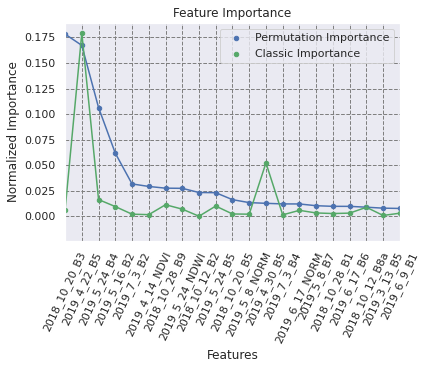

In [594]:
plt.figure(figsize=(15,10))
ax=new_perm.plot(x="pred", y="normalized", color='b', label='_nolegend_');
new_perm.plot.scatter(x="pred", y="normalized", color='b', label='Permutation Importance', ax=ax);
new_perm.plot(x="pred", y="feat_imp", color='g', label='_nolegend_', ax=ax);
new_perm.plot.scatter(x="pred", y="feat_imp", color='g', label='Classic Importance', ax=ax);
plt.xticks(new_perm.index, new_perm['pred'], rotation=65)
#plt.xticks(perm_resultsdf.index, rotation=65)
#plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='--', linewidth=1)
# Add title and axis names

plt.xlim([0,20])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.legend(loc=0)
#perm_resultsdf.plot(xlabel="new x", ylabel="new y");

In [449]:
perm_resultsdf

pred  score  normalized  feat_imp
0      F0   0.61        0.31      0.00
129  F129   0.25        0.13      0.07
249  F249   0.17        0.08      0.04
134  F134   0.15        0.07      0.11
116  F116   0.15        0.07      0.01
..    ...    ...         ...       ...
56    F56  -0.00       -0.00      0.00
16    F16  -0.00       -0.00      0.00
205  F205  -0.00       -0.00      0.00
207  F207  -0.00       -0.00      0.00
29    F29  -0.00       -0.00      0.00

[260 rows x 4 columns]

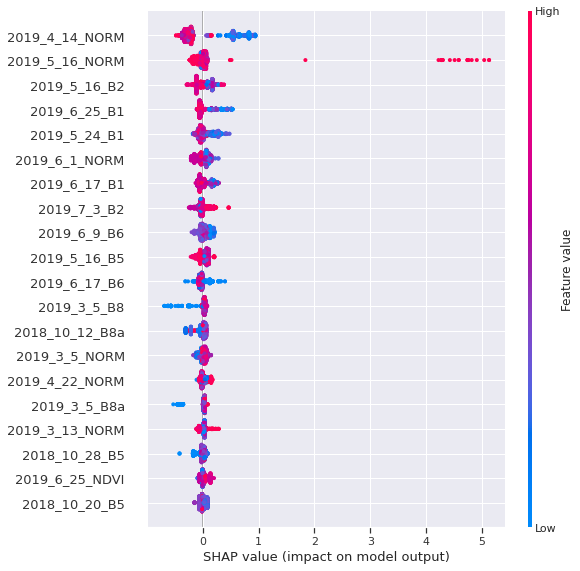

In [595]:
import shap  # pip install shap
import xgboost as xgb

# Load and train a model
#X, y = shap.datasets.diabetes()
clf = xgb.XGBRegressor().fit(X, y)

# Explain model's predictions with SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X)

# Visualize the predictions' explanation
#shap.plots.beeswarm(shap_values, show=False)
#shap.summary_plot(shap_values, final_model_features)
fig = plt.figure(figsize=(15,10))
fig = shap.summary_plot(shap_values,show=False)
plt.savefig('shap_bar_plot1.jpg',bbox_inches='tight', dpi=150)
#plt.savefig('scratch.png', show=False)#, show=False)
#plt.savefig('books_read.png')

In [596]:
%matplotlib inline

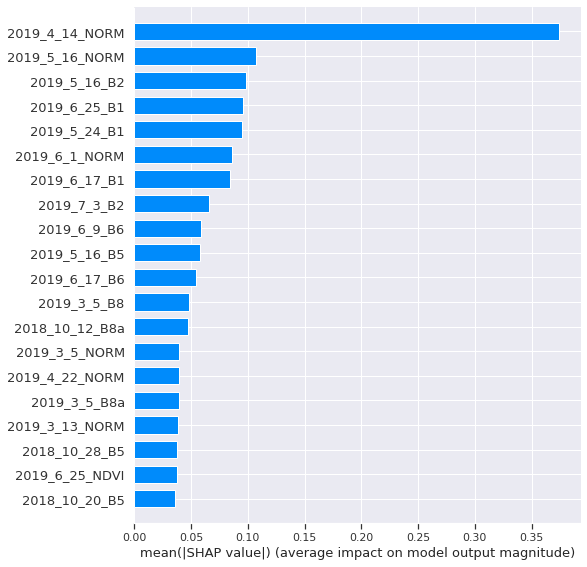

In [597]:
fig = plt.figure(figsize=(15,10))
shap.summary_plot(shap_values, X_train, plot_type="bar",show=False)
plt.savefig('shap_bar_plot2.jpg',bbox_inches='tight', dpi=150)
#plt.savefig('grafic.png', dpi=300, bbox_inches='tight')

# End of file. After this point - at your own risk:)  

AttributeError: 'Explanation' object has no attribute 'ndim'

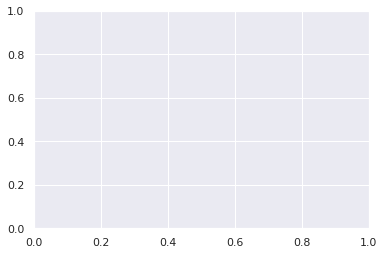

In [279]:
import matplotlib.pyplot as plt
#plt.plot(x,y)
plt.plot(shap_values)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [286]:
result = perm_resultsdf.keys()

# creating dataframe
df = pd.DataFrame({
    result[0]: perm_resultsdf[result[0]],
    result[1]: perm_resultsdf[result[1]]
})
#perm_resultsdf.values()

In [287]:
import pandas as pd
from matplotlib import pyplot as plt 
df.plot()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [ ]:
df = pd.DataFrame(np.random.random_sample((10,2)), columns=['col1', 'col2'])
fig, ax = plt.subplots()

df['col1'].plot(kind='bar', ax=ax)
df['col2'].plot(ax=ax, marker='o', ls='-')
ax.legend(loc='best')

In [ ]:
import matplotlib.pyplot as plt
df.plot(x='pred',y='score', kind='bar')

In [ ]:

rf=RandomForestRegressor(n_estimators=100)#Classifier(n_estimators=100)
rf.fit(X_train, ny_train)

In [ ]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    #bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=metric(y, clf.predict(X))
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1))
            scores[c].append(baseline_metric-score)
        #bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
baseline, scores=PermImportance(X_test, ny_test, rf, recall_score, num_iterations=10)

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(list(y), list(oof_preds)))
print('XGBoost model accuracy score: {0:0.4f}'. format(gbm.score(X_test, y_test)))
print("Accuracy: %.2f%%" % (accuracy *100.0))

In [ ]:
from scipy.stats import norm

In [227]:
# Total difference between predicted and correct yield

dist = np.linalg.norm(list(y_test)-gbm.predict(X_test))
print("The total error for predicted yield (From the true yield) is (norm-2): ", dist)
print("The cross-validation score (5-split) is ", cv_score_)

The total error for predicted yield (From the true yield) is (norm-2):  0.002158976736021441
The cross-validation score (5-split) is  8.672742245509831e-05


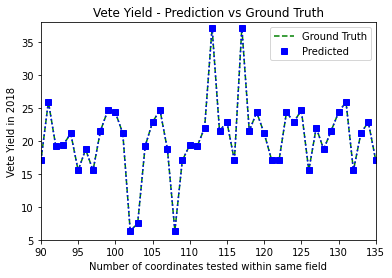

In [231]:
exact  = list(y_test)
approx = list(gbm.predict(X_test))

plt.plot(exact, '--g', label='Ground Truth')
plt.plot(exact, '.g')

plt.plot(approx,  'bs', label='Predicted')
plt.plot(approx, 'b:')
plt.ylabel('Vete Yield in 2018')
plt.xlabel('Number of coordinates tested within same field')
plt.title("Vete Yield - Prediction vs Ground Truth")
plt.axis([90, 135, 5, 38])
leg = plt.legend()
plt.show()

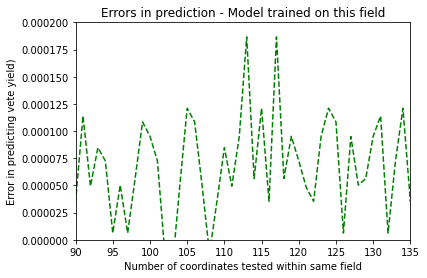

In [233]:

err = [exact[l]-approx[l] for l in range(len(exact))]

plt.plot(err, '--g')

plt.ylabel('Error in predicting vete yield)')
plt.xlabel('Number of coordinates tested within same field')
plt.title("Errors in prediction - Model trained on this field")
plt.axis([90, 135, 0, 0.0002])
#leg = plt.legend()
plt.show()

# Feature selection

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top features - feature importance')

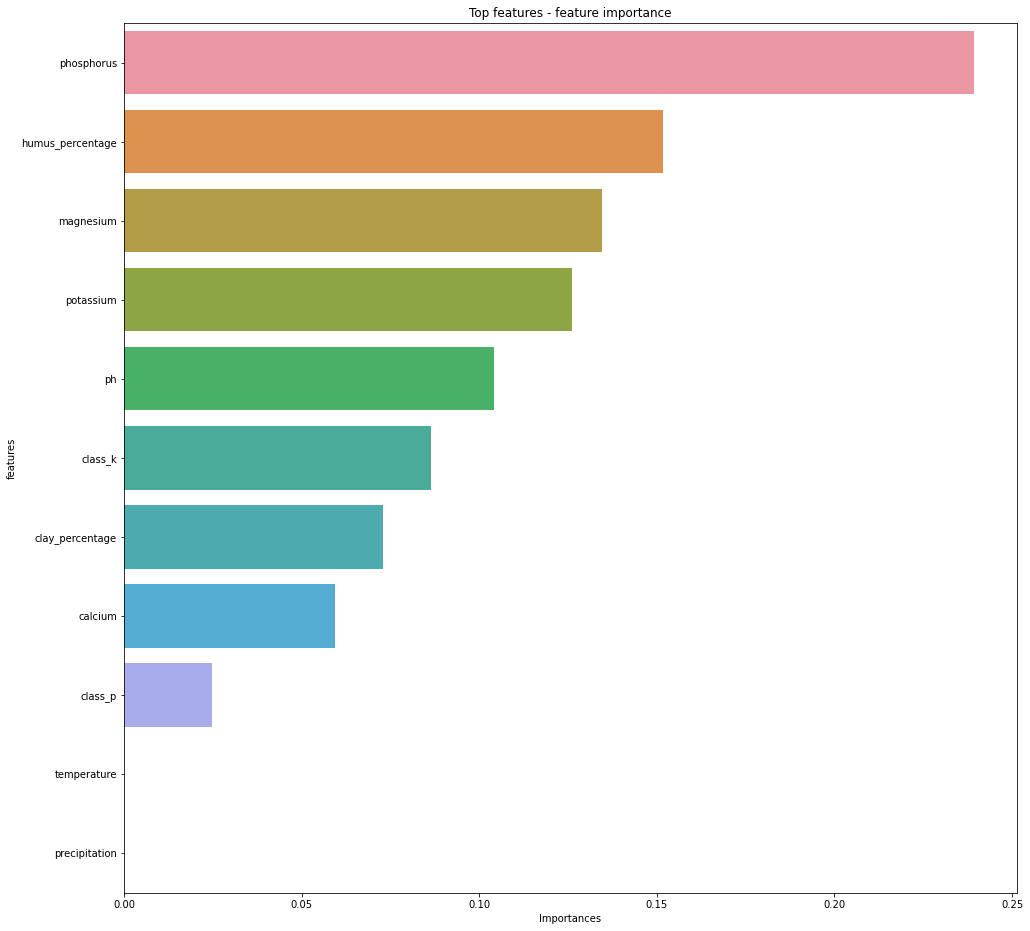

In [234]:
plt.figure(figsize=(16,16))
sns.barplot(data=feats.sort_values(by='Importances', ascending=False).head(70), x='Importances', y='features')
plt.title('Top features - feature importance')

In [ ]:
print("File ends here!")

File ends here!


In [340]:
label_count=len(np.floor(rev_y_train_unique))

In [303]:
%%time

# Set up training classes
rev_y_train = np.floor(y_train)#[np.argmax(y, axis=None, out=None) for y in y_train]
rev_y_train_unique = np.unique(rev_y_train)

# reshape features from count-timeframes-features to timeframes-count-features
#a, b, c = X_train.shape
#X_train_lgbm = X_train.reshape(a,b * c)
X_train_lgbm = X_train

# Set up the LightGBM model
model_lgbm = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(rev_y_train_unique), 
    metric='multi_logloss'
)

# Train the model
model_lgbm.fit(X_train_lgbm, rev_y_train)

# Save the model
#joblib.dump(model_lgbm, os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))

<IPython.core.display.Javascript object>

CPU times: user 3min 51s, sys: 310 ms, total: 3min 51s
Wall time: 4.3 s


LGBMClassifier(metric='multi_logloss', num_class=11, objective='multiclass')

In [306]:
# reshape features from count-timeframes-features to timeframes-count-features
# and set up training classes
#d, e, f = X_test.shape
#X_test_lgbm = X_test.reshape(d, e * f)
X_test_lgbm = X_test
rev_y_test = np.floor(y_test)#[np.argmax(y, axis=None, out=None) for y in y_test]

# Load the models
#model_lgbm = joblib.load(os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))
#model_tcnn = load_model(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

# get overall accuracy and weighted F1-score for LightGBM
py_test_lgbm = model_lgbm.predict(X_test_lgbm)
print('Classification accuracy LightGBM {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_lgbm)))
print('Classification F1-score LightGBM {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_lgbm, average='weighted')))

#py_test_tcnn = np.argmax(model_tcnn.predict(X_test), axis=-1)
#print('Classification accuracy TempCNN {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_tcnn)))
#print('Classification F1-score TempCNN {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_tcnn, average='weighted')))

Classification accuracy LightGBM 100.0%
Classification F1-score LightGBM 100.0%


In [325]:
#pip install eo-learn

In [322]:
# set module directory to system path
import sys, os
MAIN_FOLDER = os.getcwd()
temp_folder = "eo-learn-master/examples/crop-type-classification/"
# os.getcwd()
import_path = os.path.join(MAIN_FOLDER, temp_folder+'Tasks')
if import_path not in sys.path:
    sys.path.append(import_path)

In [334]:
from CropTypeClassTasks import plot_confusion_matrix, PredictPatch, AddAreaRatio, FixLPIS, masking
from CropTypeClassTasks import get_patch_list, train_test_split_eopatches, train_test_split_eopatch

In [327]:
fig = plt.figure(figsize=(20, 20))
conf_matrix_gbm = metrics.confusion_matrix(rev_y_test, py_test_lgbm)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (CROPS)',
                      xlabel='Predicted (LightGBM)',
                      title='Confusion matrix');

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'class_names' is not defined

<Figure size 1440x1440 with 0 Axes>

In [332]:
## Combine samples and split into train and test data
grouping_id=4
test_ratio = 4 # take every xth patch for testing
features_dict = 'FEATURES_SAMPLED' # name of the dictionary where the sample features are saved
labels_dict = 'LPIS_class_{}_ERODED_SAMPLED'.format(grouping_id) # name of the dictionary where the sample labels are saved
# Deep Learning
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical

In [336]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None,test_size=0.25)
nX_train, nX_test, ny_train, ny_test, n_timesteps, n_features = train_test_split_eopatches(X,#eopatches, 
                                                                  test_ratio, 
                                                                  features_dict, 
                                                                  labels_dict)

KeyError: 0

In [341]:
%%time

n_timesteps= 175
n_features = 17
# Set up the TempCNN architecture
model_tcnn = Sequential()
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Flatten())
model_tcnn.add(Dense(256, activation='relu'))
model_tcnn.add(Dense(label_count, activation='softmax'))
model_tcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_tcnn.fit(X_train, 
          y_train, 
          validation_data=(X_test, y_test), 
          epochs=20, 
          batch_size=32, 
          verbose=1,  
          shuffle=True)

# Save the model
model_tcnn.save(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

Epoch 1/20


ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 11)


In [1]:

raise SystemExit("I stopped the code here. ")


SystemExit: I stopped the code here. 

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# pick_AOI = "Heddinge" 
# fieldID = "62233175597"#
# fieldID = "61663398164"#61653396999"
# linkhttp = "http://172.16.16.50:8080/fields/"+pick_AOI
# linkhttp = "http://172.16.16.50:8080/field/soil/"+fieldID+"?format={formats}&words={words}&paragraphs={paragraphs}"
# #linkhttp = "http://172.16.16.50:8080/field/weather/"+fieldID+"?format={formats}&words={words}&paragraphs={paragraphs}"
# #linkhttp = "http://172.16.16.50:8080/weather/Heddinge"
# #linkhttp = "http://172.16.16.50:8080/field/harvest/"+fieldID
# #linkhttp = "http://172.16.16.50:8080/fields/year/"+fieldID

# #linkhttp = "http://agri.snap.lab:8080/field/year/"+fieldID

# response = requests.get(linkhttp)
# response.text

In [ ]:
#    response = requests.get(linkhttp+"?format={formats}&words={words}&paragraphs={paragraphs}")
#    if response:
#        print('Request is successful.')
#        dataout = response.json()
#        print(response.text)
#    else:
#      print('Request returned an error.') 
#    #return dataout

In [122]:
X_test.iloc[1,:]

temperature          8.20
precipitation       10.00
ph                   6.80
calcium            180.00
class_k              4.00
class_p              4.00
magnesium            6.40
potassium           17.00
phosphorus           9.20
clay_percentage     13.00
humus_percentage     3.00
Name: 6, dtype: float64

In [248]:
from PIL import Image
from matplotlib.pyplot import imshow

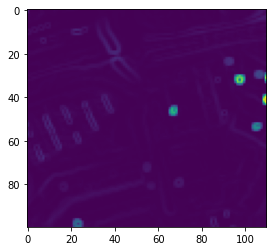

In [285]:
im = Image.open('heddingeImages/slope.tif')
im.show()
imarray = np.array(im)
imshow(np.asarray(imarray[100:200,490:600]))

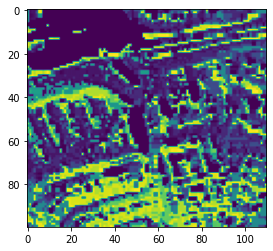

In [283]:
#im = Image.open('heddingeImages/flowacc.tif')
im = Image.open('heddingeImages/direction.tif')
imarray = np.array(im)
imshow(np.asarray(imarray[100:200,490:600]))
